In [1]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px


sns.set()

%matplotlib inline
plt.style.use('bmh')

In [2]:
# Load the CSV file directly from the ZIP
df = pd.read_csv('train_dataset_full.csv.zip', low_memory=False)

In [3]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,98528.0,2017-07-04 16:42,7716.0,C,405490.0,60305.0,3.0,NaN,3.0,Male,3.0,3.0,NaN,1.0,1.0
1,589714.0,2017-07-07 07:40,1035283.0,I,118601.0,28529.0,4.0,82527.0,10.0,Female,4.0,3.0,3.0,1.0,0.0
2,478652.0,2017-07-07 20:42,65994.0,H,359520.0,13787.0,4.0,NaN,4.0,Male,4.0,3.0,2.0,0.0,0.0
3,34536.0,2017-07-05 15:05,75976.0,H,405490.0,60305.0,3.0,NaN,3.0,Male,3.0,3.0,3.0,0.0,0.0
4,71863.0,2017-07-06 20:11,987498.0,C,405490.0,60305.0,3.0,NaN,2.0,Male,2.0,3.0,2.0,0.0,0.0


#### LabelEncoder is a class in the sklearn.preprocessing module of Scikit-learn used to encode target labels

for example:
['cat', 'dog', 'mouse'] → [0, 1, 2]

In [4]:
from sklearn.preprocessing import LabelEncoder
df = df.dropna(subset=['gender','product'])

LE = LabelEncoder()
df['gender'] = LE.fit_transform(df['gender'])

print("Gender Mapping:")
for idx, label in enumerate(LE.classes_):
    print(f"{label} -> {idx}")

df['product'] = LE.fit_transform(df['product'])

print("product Mapping:")
for idx, label in enumerate(LE.classes_):
    print(f"{label} -> {idx}")

Gender Mapping:
Female -> 0
Male -> 1
product Mapping:
A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6
H -> 7
I -> 8
J -> 9


In [5]:
filter_df = df.copy()
filter_df = filter_df.drop_duplicates(keep='first')

In [6]:
# Total missing values per column
null_count = filter_df.isnull().sum()

# Percentage of missing values per column
null_percentage = (filter_df.isnull().mean() * 100).round(2)

# Create a summary DataFrame
null_summary = pd.DataFrame({
    "Missing Count": null_count,
    "Missing Percentage (%)": null_percentage
}).sort_values(by="Missing Count", ascending=False)

In [7]:
null_summary

,Missing Count,Missing Percentage (%)
product_category_2,277348,79.01
city_development_index,84817,24.16
campaign_id,653,0.19
webpage_id,639,0.18
DateTime,638,0.18
user_depth,636,0.18
product_category_1,630,0.18
age_level,629,0.18
user_group_id,627,0.18
is_click,623,0.18


Since gender,age_level,user_depth are 5% of the data are NULLs I will remove them. 

In [8]:
# Filter out rows with missing is_click values
filter_df = filter_df.dropna(subset=['is_click','gender','age_level','user_depth','session_id','user_id','product_category_1'])

<Axes: >

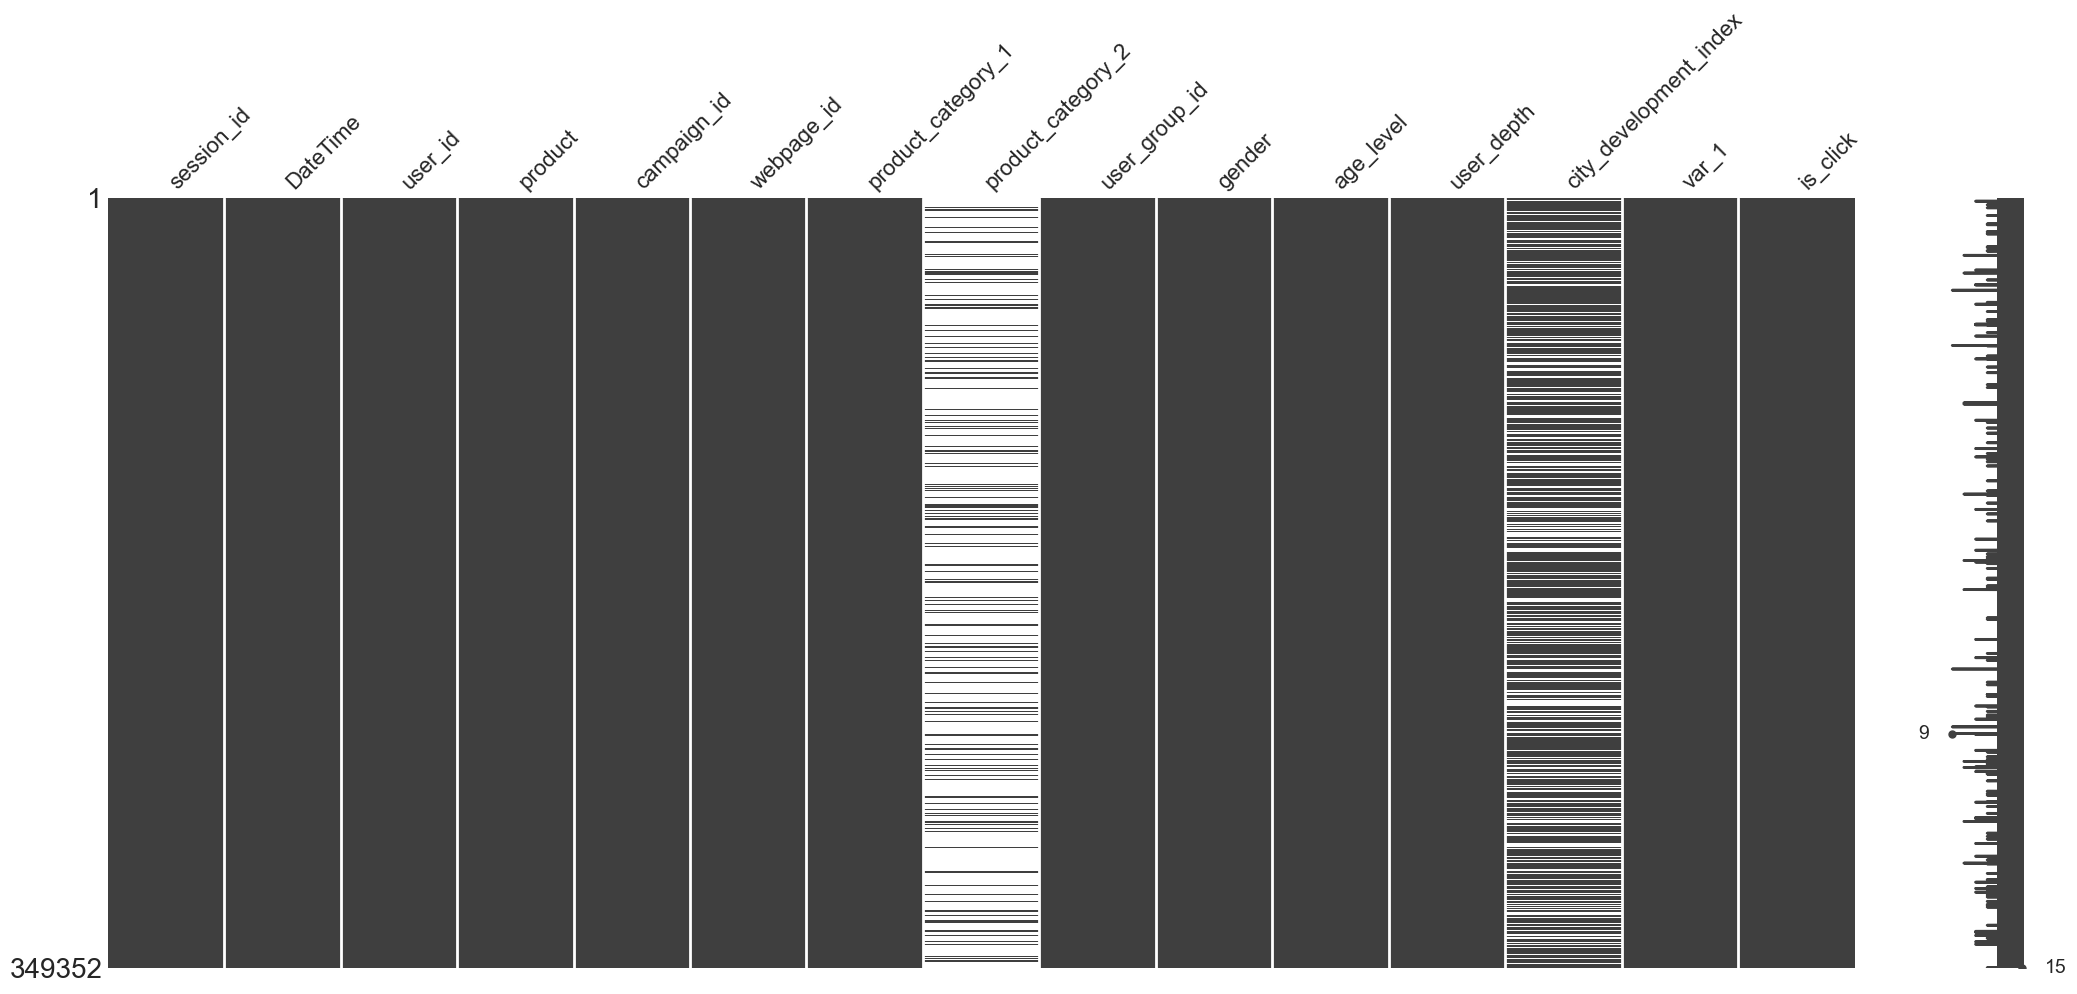

In [9]:
import missingno as msno
msno.matrix(filter_df)

The visualization above highlights the NULL values in our DataFrame. We notice missing data in the product_category_2 and city_development_index columns, but we can disregard it for now.

In [10]:
# Convert to datetime 
filter_df['DateTime'] = pd.to_datetime(filter_df['DateTime'], dayfirst=True, errors='coerce')

# Extract date for daily analysis
filter_df['date'] = filter_df['DateTime'].dt.date

# Add Hour column
filter_df['hour'] = filter_df['DateTime'].dt.hour

In [11]:
filter_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 349352 entries, 0 to 370631
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              349352 non-null  float64       
 1   DateTime                349247 non-null  datetime64[ns]
 2   user_id                 349352 non-null  float64       
 3   product                 349352 non-null  int64         
 4   campaign_id             349247 non-null  float64       
 5   webpage_id              349255 non-null  float64       
 6   product_category_1      349352 non-null  float64       
 7   product_category_2      73431 non-null   float64       
 8   user_group_id           349264 non-null  float64       
 9   gender                  349352 non-null  int64         
 10  age_level               349352 non-null  float64       
 11  user_depth              349352 non-null  float64       
 12  city_development_index  265351 non-

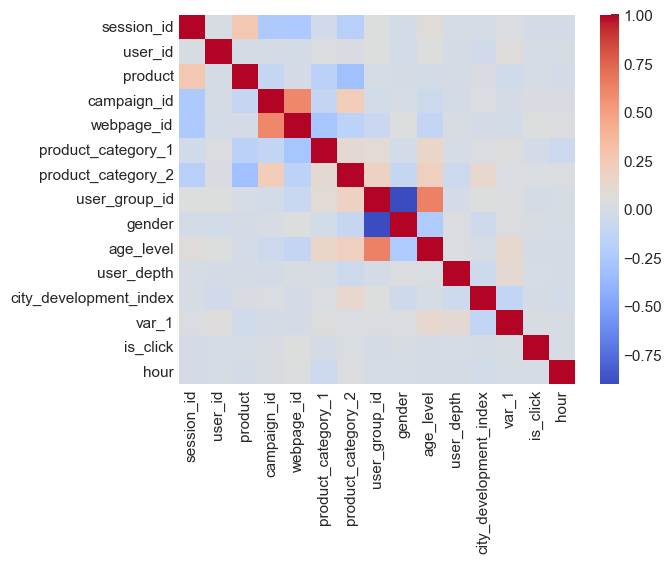

In [12]:
sns.heatmap(filter_df.corr(numeric_only=True), cmap="coolwarm")
plt.show()

We observe a correlation between age_level and user_group_id, suggesting they likely represent the same metric. Additionally, there is a strong negative correlation between gender and user_group_id.

campaign_id and webpage also show some correlation, so for now, we can assume each campaign is associated with a unique webpage.

### Explore the relationship between demographic features (gender, age_level, city_development_index, user_group_id) and the likelihood of clicking.


In [13]:
cols = ['gender', 'age_level', 'city_development_index', 'user_group_id', 'is_click']
demographic_df = filter_df[cols].copy()
demographic_df.head()

,gender,age_level,city_development_index,user_group_id,is_click
0,1,3.0,NaN,3.0,1.0
1,0,4.0,3.0,10.0,0.0
2,1,4.0,2.0,4.0,0.0
3,1,3.0,3.0,3.0,0.0
4,1,2.0,2.0,2.0,0.0


In [14]:
correlations = demographic_df[['age_level', 'city_development_index', 'user_group_id', 'is_click']].corr()
print("Correlations:\n", correlations['is_click'])

Correlations:
 age_level                -0.009474
city_development_index   -0.004899
user_group_id            -0.007994
is_click                  1.000000
Name: is_click, dtype: float64


The correlations indicate a very weak relationship between `is_click` and `age_level`, `city_development_index`, and `user_group_id`.  

In [15]:
demographic_df.groupby(['gender','age_level']).size()

gender  age_level
0       0.0              23
        1.0            1137
        2.0            4914
        3.0           15944
        4.0           10868
        5.0            6983
        6.0             834
1       0.0              99
        1.0           32863
        2.0          107774
        3.0          110032
        4.0           39263
        5.0           17238
        6.0            1380
dtype: int64

The age_level column has low representation in our dataset and may be disregarded later.

In [16]:
demographic_df = demographic_df[demographic_df['age_level'] != 0]

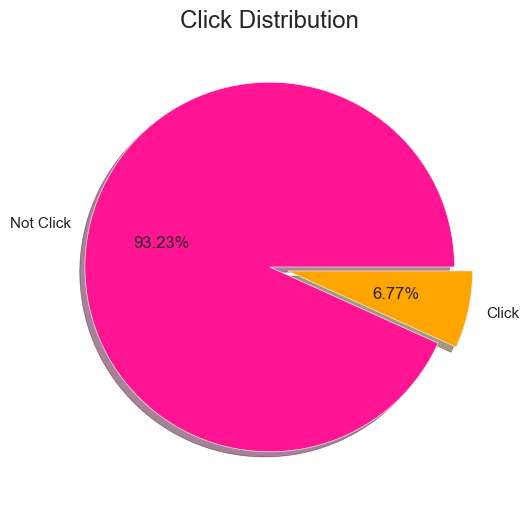

In [17]:
labels = ['Not Click', 'Click'] 
size = demographic_df['is_click'].value_counts() 
colors = ['deeppink', 'orange'] 
explode = [0, 0.1] 
plt.figure(figsize=(6,6)) 
plt.pie(size, colors=colors, explode=explode, labels=labels, shadow=True, autopct='%.2f%%')
plt.title("Click Distribution") 
plt.show() 

In [18]:
gender_click_rate = demographic_df.groupby('gender')['is_click'].mean()

age_level_click_rate = demographic_df.groupby('age_level')['is_click'].mean()

city_dev_click_rate = demographic_df.groupby('city_development_index')['is_click'].mean()

user_group_click_rate = demographic_df.groupby('user_group_id')['is_click'].mean()

print("Click Rate by Gender:\n", gender_click_rate)
print('-' * 50)
print("\nClick Rate by Age Level:\n", age_level_click_rate)
print('-' * 50)
print("\nClick Rate by City Development Index:\n", city_dev_click_rate)
print('-' * 50)
print("\nClick Rate by User Group ID:\n", user_group_click_rate)

Click Rate by Gender:
 gender
0    0.064381
1    0.068089
Name: is_click, dtype: float64
--------------------------------------------------

Click Rate by Age Level:
 age_level
1.0    0.074324
2.0    0.071161
3.0    0.064782
4.0    0.058487
5.0    0.074687
6.0    0.081301
Name: is_click, dtype: float64
--------------------------------------------------

Click Rate by City Development Index:
 city_development_index
1.0    0.067250
2.0    0.070308
3.0    0.064778
4.0    0.066869
Name: is_click, dtype: float64
--------------------------------------------------

Click Rate by User Group ID:
 user_group_id
1.0     0.074661
2.0     0.071435
3.0     0.064982
4.0     0.059382
5.0     0.073517
6.0     0.079043
7.0     0.065084
8.0     0.065147
9.0     0.063363
10.0    0.055305
11.0    0.077617
12.0    0.085234
Name: is_click, dtype: float64


## Let's examine the significant differences between genders and their click behavior.

Gender Mapping:
Female -> 0
Male -> 1

In [19]:
Male = df[df['gender']==1]
Female = df[df['gender']==0]

print(f"Male click rate: {round(100*sum(Male['is_click']==1)/Male.shape[0],2)}%")
print(f"Female click rate: {round(100*sum(Female['is_click']==1)/Female.shape[0],2)}%")

Male click rate: 6.79%
Female click rate: 6.43%


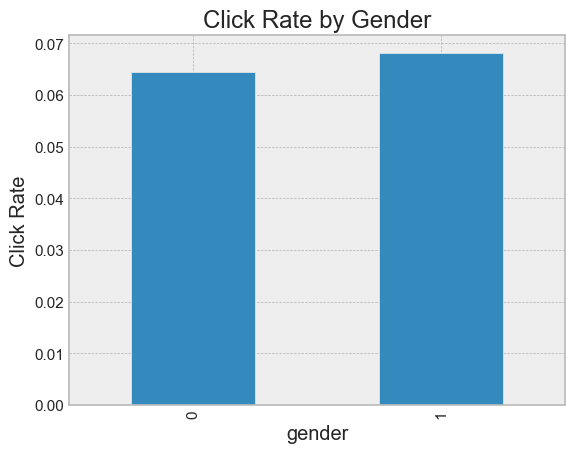

In [20]:
# Bar plot for gender
demographic_df.groupby('gender')['is_click'].mean().plot(kind='bar', title='Click Rate by Gender')
plt.ylabel('Click Rate')
plt.show()

In [22]:
from scipy.stats import ttest_ind

df_gender_ctr = df.groupby(["user_id","gender"], as_index=False).agg(
    clicks=("is_click","sum"), 
    impressions=("is_click","count")
    )

df_gender_ctr["ctr"] = df_gender_ctr["clicks"]/df_gender_ctr["impressions"]

# CTR mean for both female and male
gender_ctr_mean = df_gender_ctr.groupby("gender")["ctr"].mean()
female_ctr = df_gender_ctr["ctr"].loc[df_gender_ctr["gender"]==0]
male_ctr = df_gender_ctr["ctr"].loc[df_gender_ctr["gender"]==1]

male_ctr = male_ctr.dropna()
female_ctr = female_ctr.dropna()

ttest_ind(male_ctr,female_ctr)

          user_id  gender  clicks  impressions       ctr
0             4.0       0     0.0            1  0.000000
1             6.0       1     0.0            1  0.000000
2            19.0       1     0.0            1  0.000000
3            25.0       1     0.0            2  0.000000
4            26.0       1     0.0            1  0.000000
...           ...     ...     ...          ...       ...
127777  1141714.0       1     1.0            1  1.000000
127778  1141716.0       1     0.0            1  0.000000
127779  1141718.0       0     2.0            3  0.666667
127780  1141723.0       1     1.0            2  0.500000
127781  1141729.0       1     0.0            3  0.000000

[127782 rows x 5 columns]


In [26]:
male_ctr = male_ctr.dropna()
female_ctr = female_ctr.dropna()

ttest_ind(male_ctr,female_ctr)

TtestResult(statistic=3.1994984691469597, pvalue=0.0013770053435911399, df=127702.0)

The t-test result shows a significant difference between male and female CTRs (t=3.20, p=0.0013). Since the p-value < 0.05, we reject the null hypothesis (H₀) and conclude that there is a statistically significant difference in CTRs between males and females. This implies that gender has an impact on CTR in this dataset.

________________________________________________________________________________________________

### statistical test to check if the differences in is_click rates across the city_development_index categories are statistically significant. For multiple categories we will run an ANOVA test

In [27]:
from scipy.stats import f_oneway

# Group the click rates by city_development_index
city_dev_groups = [group['is_click'].values for _, group in demographic_df.groupby('city_development_index')]

# Perform the ANOVA test
anova_result = f_oneway(*city_dev_groups)

print("ANOVA Result for City Development Index and CTR:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")


ANOVA Result for City Development Index and CTR:
F-statistic: 7.468638809694105, p-value: 5.372206070500487e-05


The ANOVA result indicates a statistically significant difference in `is_click` rates across the `city_development_index` groups (F-statistic = 7.43, p-value = 5.65e-05). This suggests that the likelihood of observing such differences by random chance is extremely low. Therefore, we reject the null hypothesis (H₀) and conclude that `city_development_index` has a significant effect on `is_click` rates.


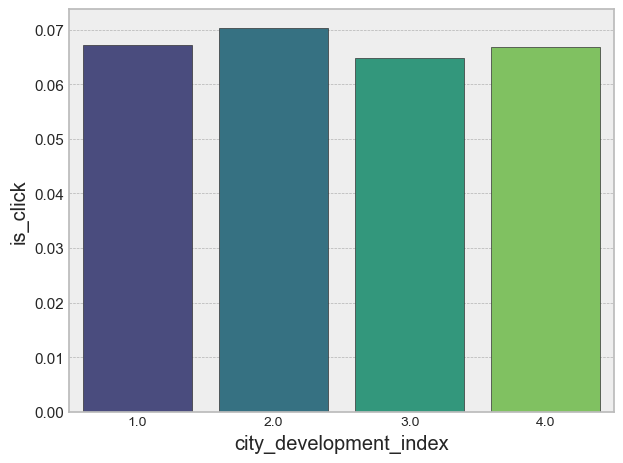

In [28]:
sns.barplot(city_dev_click_rate.reset_index(), 
            x="city_development_index", 
            y="is_click",
            palette="viridis", 
            edgecolor=".2"  
            )
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

### Investigate whether certain user segments (e.g., age groups or genders) exhibit higher CTR.

In [29]:
pivot = demographic_df.pivot_table(
    index='gender', 
    columns='age_level', 
    values='is_click', 
    aggfunc='mean'
)
pivot

age_level,1.0,2.0,3.0,4.0,5.0,6.0
gender,,,,,,
0,0.065084,0.065324,0.063347,0.055300,0.077617,0.085132
1,0.074643,0.071427,0.064990,0.059369,0.073500,0.078986


In [30]:
max_per_gender = pivot.max(axis=1) 
age_level_for_max = pivot.idxmax(axis=1)
result = pd.DataFrame({
    'Max Click Rate': max_per_gender,
    'Age Level': age_level_for_max
})

print(result)

        Max Click Rate  Age Level
gender                           
0             0.085132        6.0
1             0.078986        6.0


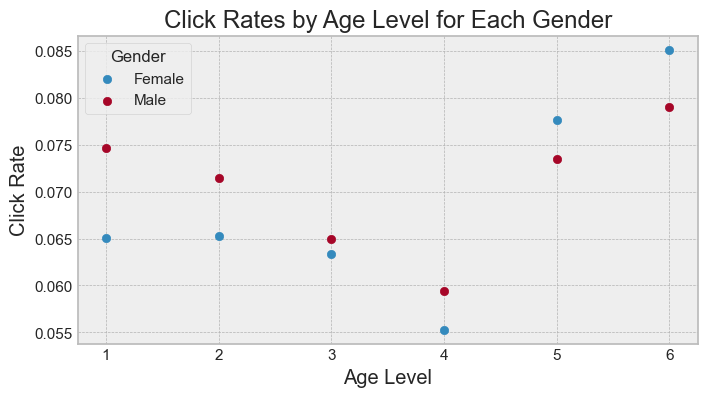

In [31]:
pivot_reset = pivot.reset_index()

plt.figure(figsize=(8, 4))
for gender, row in pivot_reset.iterrows():
    age_levels = pivot.columns
    click_rates = row[1:]  
    plt.scatter(age_levels, click_rates, label='Female' if row['gender'] == 0 else 'Male')

plt.title('Click Rates by Age Level for Each Gender')
plt.xlabel('Age Level')
plt.ylabel('Click Rate')
plt.legend(title='Gender')
plt.grid(True)
plt.show() 

It seems that the maximum click rate occurs at Age Level 6 for both males and females.

### Examine whether specific campaign_ids or product_category combinations have significantly different CTRs.

In [32]:
# CTR by campaign_id
ctr_by_campaign = (filter_df.groupby("campaign_id")
                   .agg(
                       total_clicks=("is_click", "sum"),
                       total_impressions=("is_click", "count"),
                       ctr=("is_click", "mean")
                   )
                   .reset_index()
                   .sort_values(by="ctr", ascending=False))  
print("CTR by campaign_id (sorted):")
ctr_by_campaign

CTR by campaign_id (sorted):


,campaign_id,total_clicks,total_impressions,ctr
8,405490.0,6595.0,72399,0.091092
7,404347.0,1667.0,21510,0.077499
1,98970.0,2028.0,26579,0.076301
6,396664.0,1336.0,18197,0.073419
2,105960.0,1328.0,19491,0.068134
0,82320.0,1297.0,20459,0.063395
9,414149.0,1309.0,22046,0.059376
4,359520.0,4847.0,81969,0.059132
3,118601.0,1457.0,27279,0.053411
5,360936.0,1769.0,39318,0.044992


In [33]:
# Prepare CTRs for ANOVA
campaign_groups = [group["is_click"].values for _, group in filter_df.groupby("campaign_id")]

# Perform ANOVA
anova_result = f_oneway(*campaign_groups)

print("ANOVA Result for campaign_id and CTR:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

ANOVA Result for campaign_id and CTR:
F-statistic: 137.88173342899202, p-value: 5.22184640573317e-261


The ANOVA result indicates a highly significant difference in CTR across the `campaign_id` groups (F-statistic = 138.03, p-value ≈ 0). This p-value suggests that the observed differences in CTR between campaigns are not due to random chance, and at least one `campaign_id` group has a CTR that is significantly different from the others. These findings reject the null hypothesis (H₀) and imply that the campaign has a significant effect on CTR.

In [34]:
# CTR by product_category_1
ctr_by_product_cat1 = (filter_df.groupby("product_category_1")
                       .agg(
                           total_clicks=("is_click", "sum"),
                           total_impressions=("is_click", "count"),
                           ctr=("is_click", "mean")
                       )
                       .reset_index()
                       .sort_values(by="ctr", ascending=False))  
print("\nCTR by product_category_1 (sorted):")
ctr_by_product_cat1


CTR by product_category_1 (sorted):


,product_category_1,total_clicks,total_impressions,ctr
2,3.0,7168.0,85744,0.083598
0,1.0,4292.0,59866,0.071693
1,2.0,3229.0,52296,0.061745
3,4.0,6013.0,101358,0.059324
4,5.0,2939.0,50088,0.058677


In [35]:
# Group CTRs by product_category_1
product_groups = [group["is_click"].values for _, group in filter_df.groupby("product_category_1")]

# Perform ANOVA
anova_result = f_oneway(*product_groups)

print("ANOVA Result for product_category_1 and CTR:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

ANOVA Result for product_category_1 and CTR:
F-statistic: 141.56230716296594, p-value: 3.916462094869407e-121


The ANOVA result indicates a highly significant difference in CTR across the `product_category_1` groups (F-statistic = 141.56, p-value ≈ 0). This p-value suggests that the observed differences in CTR between product categories are not due to random chance, and at least one `product_category_1` group has a CTR that is significantly different from the others. This finding allows us to reject the null hypothesis (H₀), concluding that `product_category_1` has a significant effect on CTR.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -0.0099    0.0  -0.014 -0.0059   True
   1.0    3.0   0.0119    0.0  0.0083  0.0156   True
   1.0    4.0  -0.0124    0.0 -0.0159 -0.0088   True
   1.0    5.0   -0.013    0.0 -0.0172 -0.0089   True
   2.0    3.0   0.0219    0.0  0.0181  0.0257   True
   2.0    4.0  -0.0024 0.3787 -0.0061  0.0013  False
   2.0    5.0  -0.0031 0.2882 -0.0073  0.0012  False
   3.0    4.0  -0.0243    0.0 -0.0274 -0.0211   True
   3.0    5.0  -0.0249    0.0 -0.0288 -0.0211   True
   4.0    5.0  -0.0006 0.9898 -0.0044  0.0031  False
----------------------------------------------------


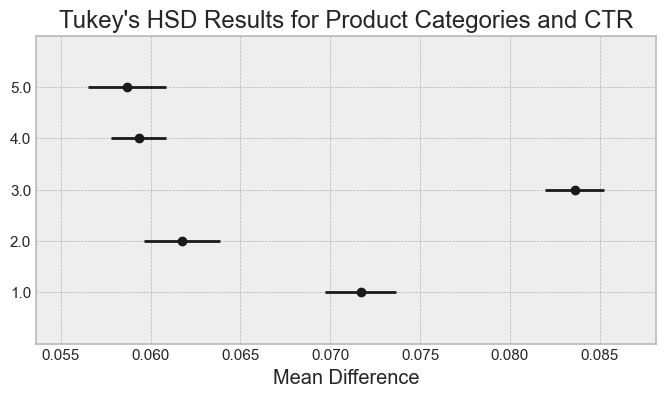

In [85]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

tukey_data = filter_df[['product_category_1', 'is_click']]

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=tukey_data['is_click'],          # Dependent variable
    groups=tukey_data['product_category_1'],  # Independent variable (grouping)
    alpha=0.05                            # Significance level
)

print(tukey_result)

tukey_result.plot_simultaneous(figsize=(8, 4))  
plt.title("Tukey's HSD Results for Product Categories and CTR")
plt.xlabel("Mean Difference")
plt.show()


Product Categories 3.0 vs Others: Product category 3.0 stands out with significant differences in CTR compared to categories 4.0 and 5.0, suggesting unique click behavior for this category.

In [37]:
# CTR by product_category_1 & campaign_id
camp_prod_final_ctr = (filter_df.groupby(["product_category_1",'campaign_id'])
                       .agg(
                           total_clicks=("is_click", "sum"),
                           total_impressions=("is_click", "count"),
                           ctr=("is_click", "mean")
                       )
                       .reset_index()
                       .sort_values(by="ctr", ascending=False))  

camp_prod_final_ctr = camp_prod_final_ctr.loc[(camp_prod_final_ctr['total_impressions'] > 1000)]

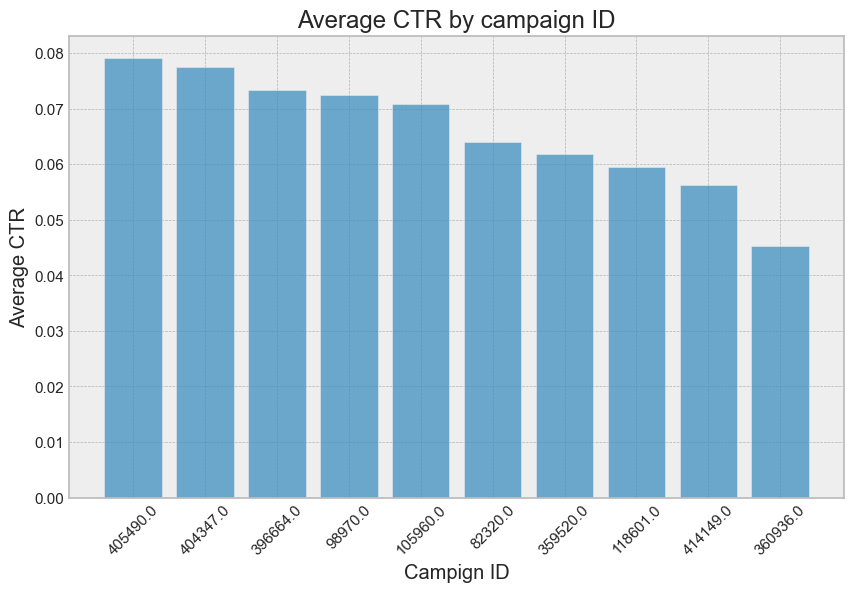

In [38]:
avg_ctr_campign = (camp_prod_final_ctr
                   .groupby('campaign_id')['ctr']
                   .mean()
                   .reset_index()
                   .sort_values(by='ctr', ascending=False))

plt.figure(figsize=(10, 6))
plt.bar(x=avg_ctr_campign['campaign_id'].astype(str), height=avg_ctr_campign['ctr'], alpha=0.7)
plt.xlabel("Campign ID")
plt.ylabel("Average CTR")
plt.title("Average CTR by campaign ID")
plt.xticks(rotation=45)
plt.show()

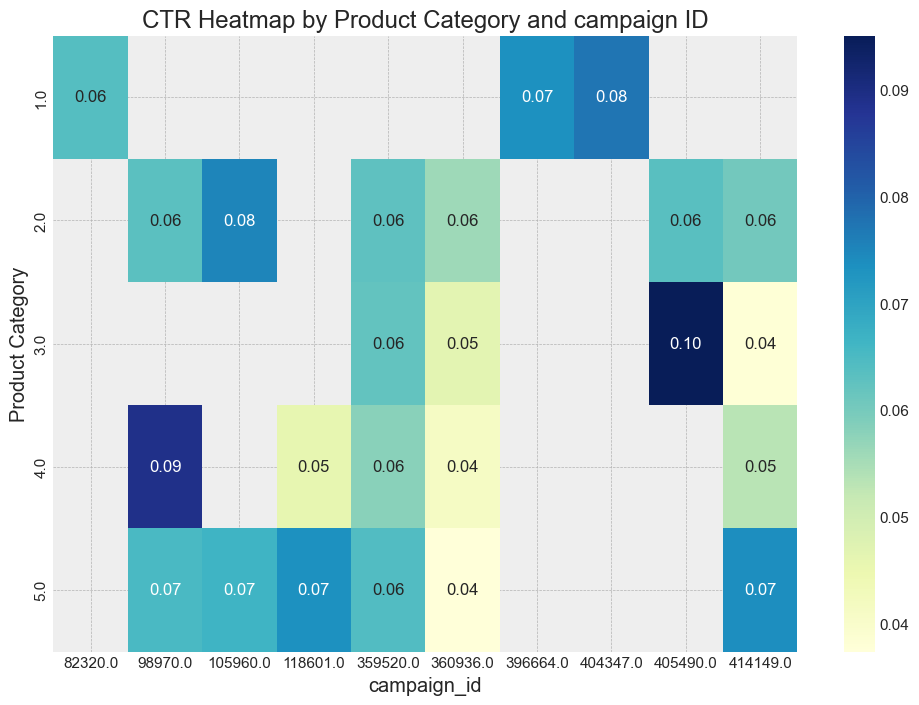

In [39]:
heatmap_data = camp_prod_final_ctr.pivot(index="product_category_1", columns="campaign_id", values="ctr")

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("CTR Heatmap by Product Category and campaign ID")
plt.xlabel("campaign_id")
plt.ylabel("Product Category")
plt.show()

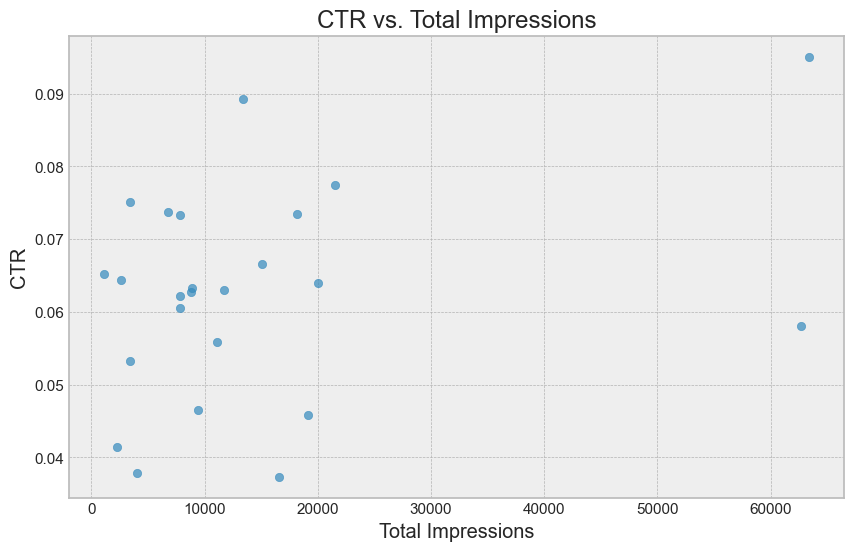

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(camp_prod_final_ctr["total_impressions"], camp_prod_final_ctr["ctr"], alpha=0.7)
plt.xlabel("Total Impressions")
plt.ylabel("CTR")
plt.title("CTR vs. Total Impressions")
plt.show() 

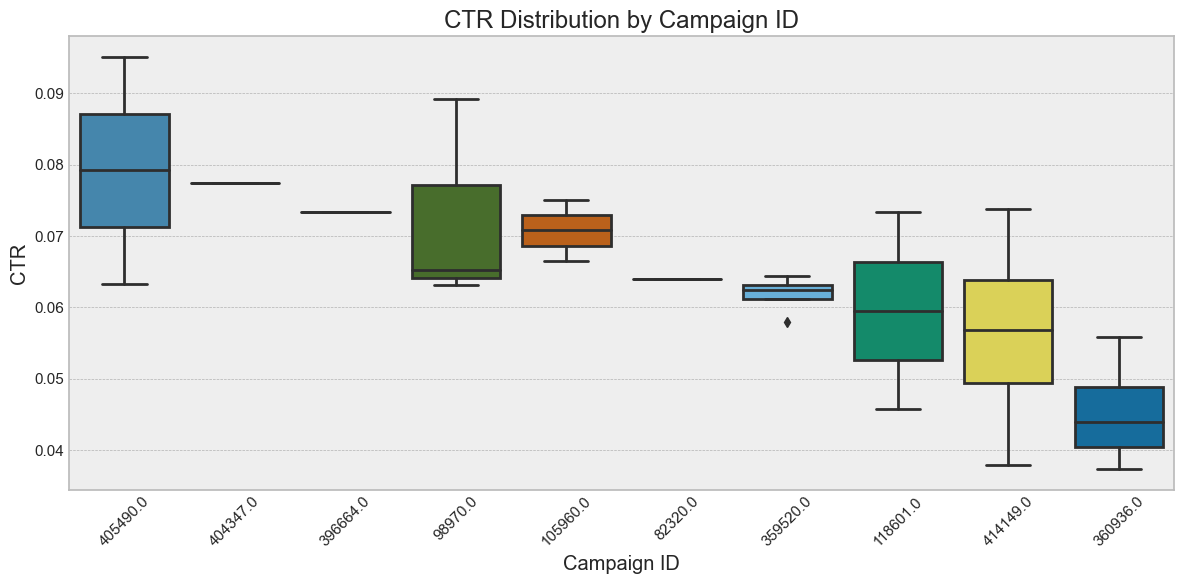

In [41]:
sorted_campaigns = camp_prod_final_ctr.groupby('campaign_id')['ctr'].mean().sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=camp_prod_final_ctr,
    x="campaign_id",
    y="ctr",
    order=sorted_campaigns  
)
plt.xlabel("Campaign ID")
plt.ylabel("CTR")
plt.title("CTR Distribution by Campaign ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Analyze patterns based on webpage_id or the product being advertised to identify ad performance trends.


Top 10 performing webpage_ids by CTR:
   webpage_id  impressions  clicks   ctr
8     60305.0        72395  6597.0  9.11
7     53587.0        21512  1667.0  7.75
1      6970.0        26576  2028.0  7.63
6     51181.0        18195  1336.0  7.34
2     11085.0        19494  1328.0  6.81
0      1734.0        20463  1296.0  6.33
5     45962.0        22053  1308.0  5.93
3     13787.0       121291  6615.0  5.45
4     28529.0        27276  1457.0  5.34


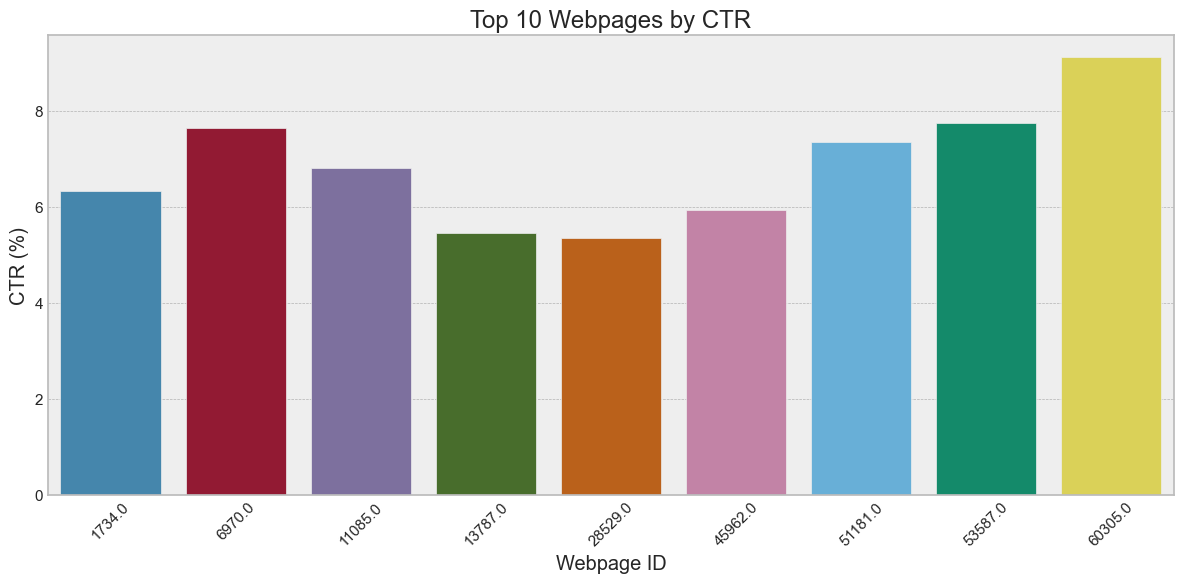


Top 10 performing products by CTR:
   product  impressions  clicks   ctr
9        9         7271   690.0  9.49
3        3        30970  2235.0  7.22
7        7        82256  5731.0  6.97
4        4        16203  1120.0  6.91
2        2       124080  8567.0  6.90
8        8        47830  3053.0  6.38
0        0        11588   730.0  6.30
1        1        16660   928.0  5.57
5        5         5257   257.0  4.89
6        6         7237   330.0  4.56


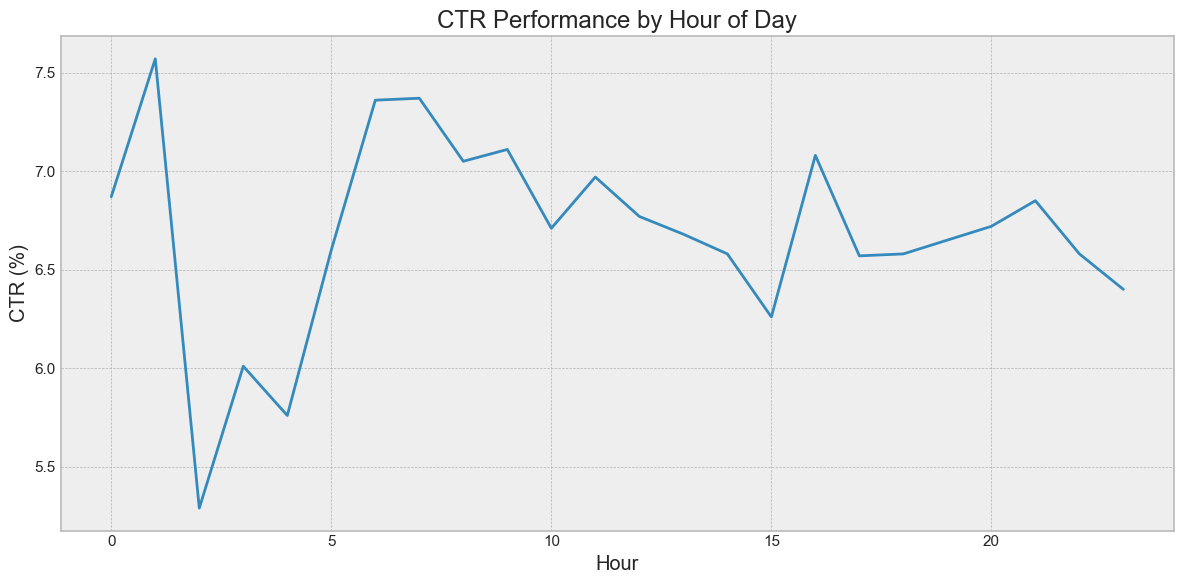


CTR by Product Category:
   category  impressions  clicks   ctr
2       3.0        85744  7168.0  8.36
0       1.0        59866  4292.0  7.17
1       2.0        52296  3229.0  6.17
3       4.0       101358  6013.0  5.93
4       5.0        50088  2939.0  5.87


In [42]:
# Calculate CTR by webpage_id
webpage_performance = filter_df.groupby('webpage_id').agg({
    'is_click': ['count', 'sum']
}).reset_index()

webpage_performance.columns = ['webpage_id', 'impressions', 'clicks']
webpage_performance['ctr'] = (webpage_performance['clicks'] / webpage_performance['impressions'] * 100).round(2)

# Filter for statistical significance (pages with > 100 impressions)
webpage_performance = webpage_performance[webpage_performance['impressions'] > 100].sort_values('ctr', ascending=False)

print("Top 10 performing webpage_ids by CTR:")
print(webpage_performance.head(10))

# Visualize top 10 webpage CTRs
plt.figure(figsize=(12, 6))
sns.barplot(data=webpage_performance.head(10), x='webpage_id', y='ctr')
plt.title('Top 10 Webpages by CTR')
plt.xticks(rotation=45)
plt.xlabel('Webpage ID')
plt.ylabel('CTR (%)')
plt.tight_layout()
plt.show()

# Product performance analysis
product_performance = filter_df.groupby('product').agg({
    'is_click': ['count', 'sum']
}).reset_index()

product_performance.columns = ['product', 'impressions', 'clicks']
product_performance['ctr'] = (product_performance['clicks'] / product_performance['impressions'] * 100).round(2)

# Filter for statistical significance
product_performance = product_performance[product_performance['impressions'] > 100].sort_values('ctr', ascending=False)

print("\nTop 10 performing products by CTR:")
print(product_performance.head(10))

# Visualize product CTR by time of day
hourly_performance = filter_df.groupby('hour').agg({
    'is_click': ['count', 'sum']
}).reset_index()

hourly_performance.columns = ['hour', 'impressions', 'clicks']
hourly_performance['ctr'] = (hourly_performance['clicks'] / hourly_performance['impressions'] * 100).round(2)

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_performance, x='hour', y='ctr')
plt.title('CTR Performance by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('CTR (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional insights: CTR by product category
if 'product_category_1' in filter_df.columns:
    category_performance = filter_df.groupby('product_category_1').agg({
        'is_click': ['count', 'sum']
    }).reset_index()
    
    category_performance.columns = ['category', 'impressions', 'clicks']
    category_performance['ctr'] = (category_performance['clicks'] / category_performance['impressions'] * 100).round(2)
    
    # Filter and sort
    category_performance = category_performance[category_performance['impressions'] > 100].sort_values('ctr', ascending=False)
    
    print("\nCTR by Product Category:")
    print(category_performance)

In [43]:
# CTR by webpage_id
ctr_by_webpage_id= (filter_df.groupby('webpage_id')
                       .agg(
                           total_clicks=("is_click", "sum"),
                           total_impressions=("is_click", "count"),
                           ctr=("is_click", "mean")
                       )
                       .reset_index()
                       .sort_values(by="ctr", ascending=False)) 

print("\nCTR by 'webpage_id' (sorted):")
ctr_by_webpage_id


CTR by 'webpage_id' (sorted):


,webpage_id,total_clicks,total_impressions,ctr
8,60305.0,6597.0,72395,0.091125
7,53587.0,1667.0,21512,0.077492
1,6970.0,2028.0,26576,0.076309
6,51181.0,1336.0,18195,0.073427
2,11085.0,1328.0,19494,0.068124
0,1734.0,1296.0,20463,0.063334
5,45962.0,1308.0,22053,0.059312
3,13787.0,6615.0,121291,0.054538
4,28529.0,1457.0,27276,0.053417


In [44]:
# CTR by product_category_1 & webpage_id
web_prod_final_ctr = (filter_df.groupby(["product_category_1",'webpage_id'])
                       .agg(
                           total_clicks=("is_click", "sum"),
                           total_impressions=("is_click", "count"),
                           ctr=("is_click", "mean")
                       )
                       .reset_index()
                       .sort_values(by="ctr", ascending=False))  

web_prod_final_ctr = web_prod_final_ctr.loc[(web_prod_final_ctr['total_impressions'] > 1000)]

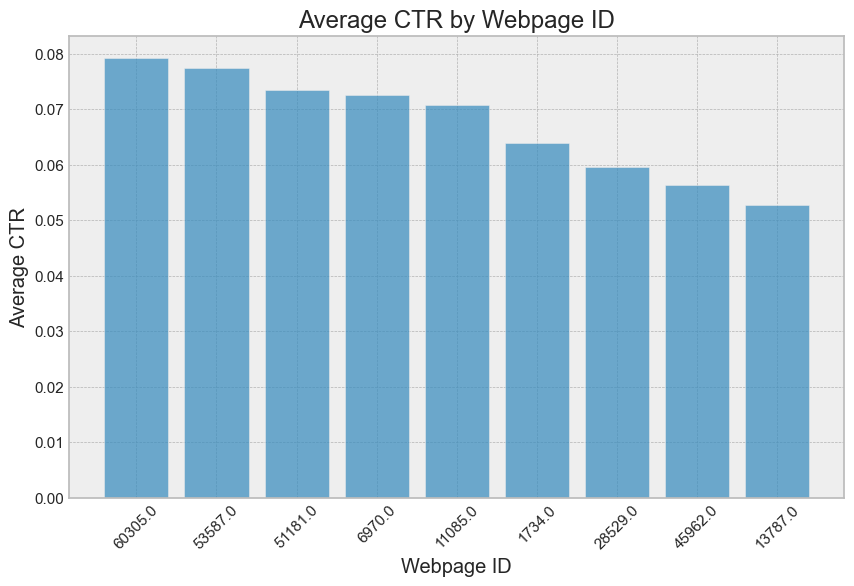

In [45]:
avg_ctr_webpage = (web_prod_final_ctr
                   .groupby('webpage_id')['ctr']
                   .mean()
                   .reset_index()
                   .sort_values(by='ctr', ascending=False))

plt.figure(figsize=(10, 6))
plt.bar(x=avg_ctr_webpage['webpage_id'].astype(str), height=avg_ctr_webpage['ctr'], alpha=0.7)
plt.xlabel("Webpage ID")
plt.ylabel("Average CTR")
plt.title("Average CTR by Webpage ID")
plt.xticks(rotation=45)
plt.show()

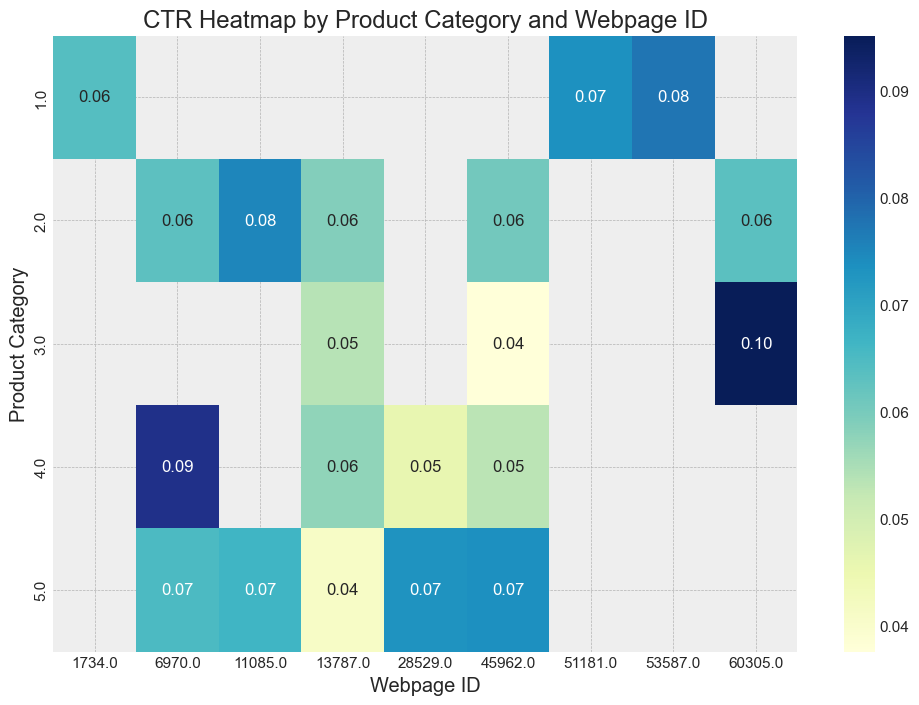

In [46]:
heatmap_data = web_prod_final_ctr.pivot(index="product_category_1", columns="webpage_id", values="ctr")

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("CTR Heatmap by Product Category and Webpage ID")
plt.xlabel("Webpage ID")
plt.ylabel("Product Category")
plt.show()

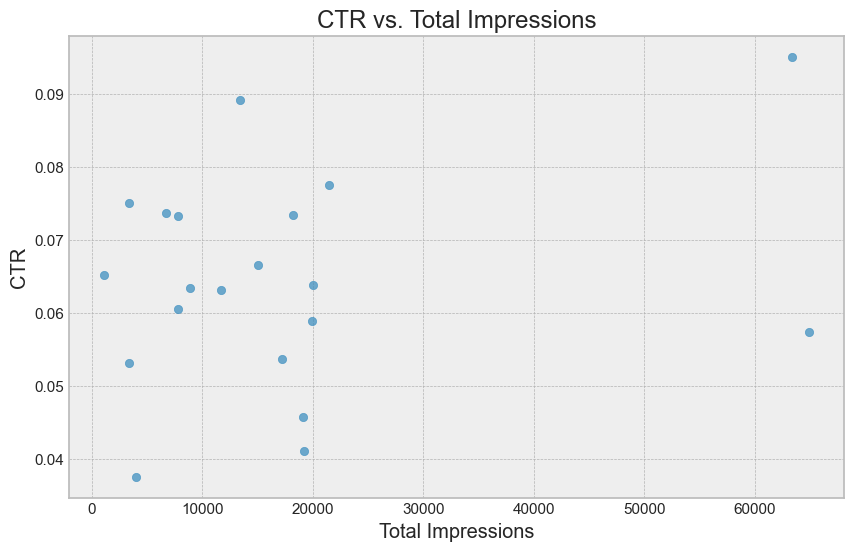

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(web_prod_final_ctr["total_impressions"], web_prod_final_ctr["ctr"], alpha=0.7)
plt.xlabel("Total Impressions")
plt.ylabel("CTR")
plt.title("CTR vs. Total Impressions")
plt.show()

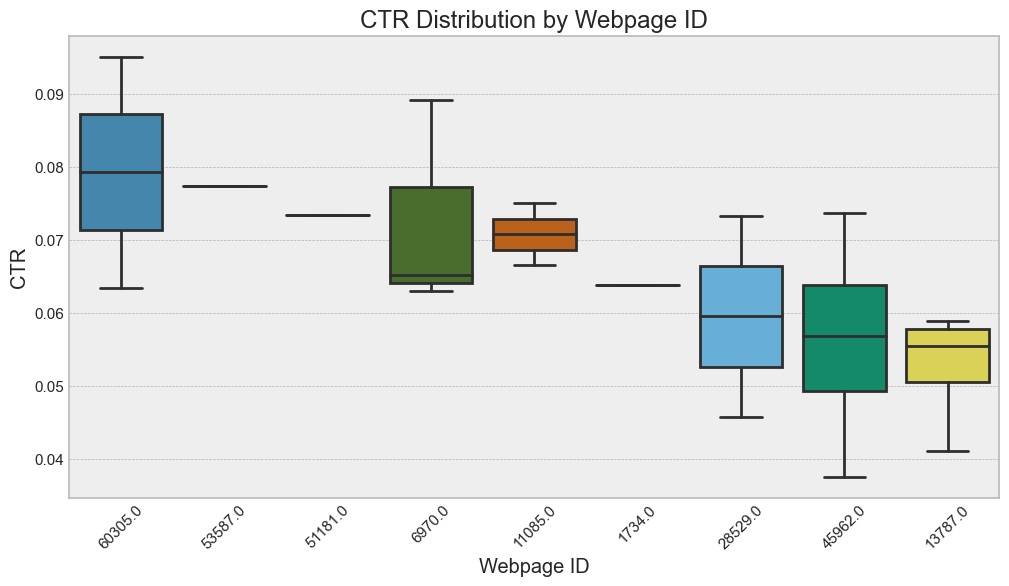

In [48]:
sorted_webpage = web_prod_final_ctr.groupby('webpage_id')['ctr'].mean().sort_values(ascending=False).index


plt.figure(figsize=(12, 6))
sns.boxplot(data=web_prod_final_ctr, x="webpage_id", y="ctr", order=sorted_webpage)
plt.xlabel("Webpage ID")
plt.ylabel("CTR")
plt.title("CTR Distribution by Webpage ID")
plt.xticks(rotation=45)
plt.show()

#### Time Analysis
#### Analyze the distribution of clicks across time (datetime) to identify trends or peak engagement periods.


In [49]:
# Check DateTime range
print("Time Range in Dataset:")
print(f"Start: {filter_df['DateTime'].min()}")
print(f"End: {filter_df['DateTime'].max()}")

# Create time features
filter_df['day_of_week'] = filter_df['DateTime'].dt.day_name()
filter_df['day_number'] = filter_df['DateTime'].dt.day

Time Range in Dataset:
Start: 2017-02-07 00:00:00
End: 2017-07-07 23:59:00


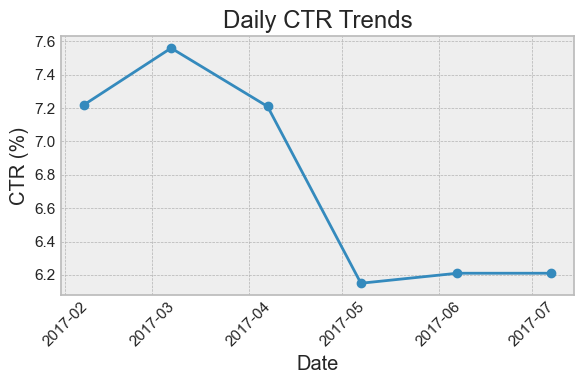


Daily CTR Statistics:
         date   ctr  impressions  clicks
0  2017-02-07  7.22        59239  4278.0
1  2017-03-07  7.56        61299  4636.0
2  2017-04-07  7.21        55026  3970.0
3  2017-05-07  6.15        60971  3748.0
4  2017-06-07  6.21        58760  3651.0
5  2017-07-07  6.21        53952  3353.0


In [50]:
# Daily trends
daily_clicks = filter_df.groupby('date').agg({
    'is_click': ['count', 'sum']
}).reset_index()
daily_clicks.columns = ['date', 'impressions', 'clicks']
daily_clicks['ctr'] = (daily_clicks['clicks'] / daily_clicks['impressions'] * 100).round(2)

plt.figure(figsize=(6, 4))
plt.plot(daily_clicks['date'], daily_clicks['ctr'], marker='o', linewidth=2)
plt.title('Daily CTR Trends')
plt.xlabel('Date')
plt.ylabel('CTR (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nDaily CTR Statistics:")
print(daily_clicks[['date', 'ctr', 'impressions', 'clicks']])

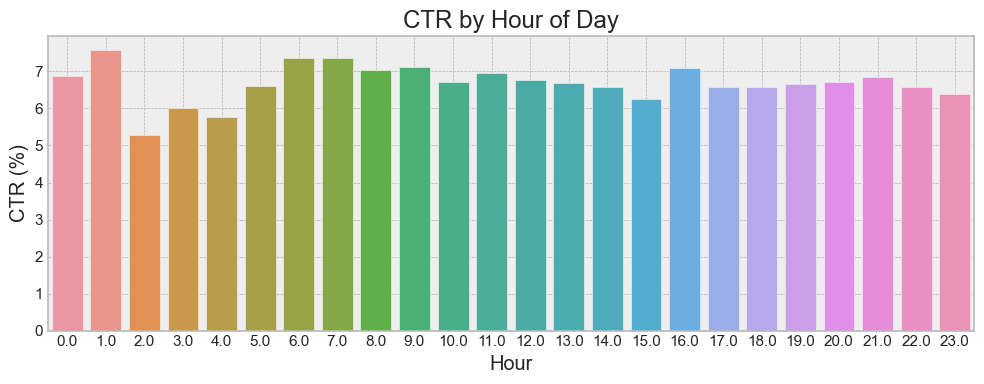


Peak Hours (Top 5):
    hour   ctr  impressions  clicks
1    1.0  7.57         1163    88.0
7    7.0  7.37        18396  1356.0
6    6.0  7.36        15683  1154.0
9    9.0  7.11        18826  1338.0
16  16.0  7.08        16199  1147.0


In [51]:
# Hourly analysis
hourly_clicks = filter_df.groupby('hour').agg({
    'is_click': ['count', 'sum']
}).reset_index()
hourly_clicks.columns = ['hour', 'impressions', 'clicks']
hourly_clicks['ctr'] = (hourly_clicks['clicks'] / hourly_clicks['impressions'] * 100).round(2)

plt.figure(figsize=(10, 4))
sns.barplot(data=hourly_clicks, x='hour', y='ctr')
plt.title('CTR by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('CTR (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nPeak Hours (Top 5):")
print(hourly_clicks.nlargest(5, 'ctr')[['hour', 'ctr', 'impressions', 'clicks']])

Data distribution by month-day:
month_day
02-07    59239
03-07    61299
04-07    55026
05-07    60971
06-07    58760
07-07    53952
Name: is_click, dtype: int64


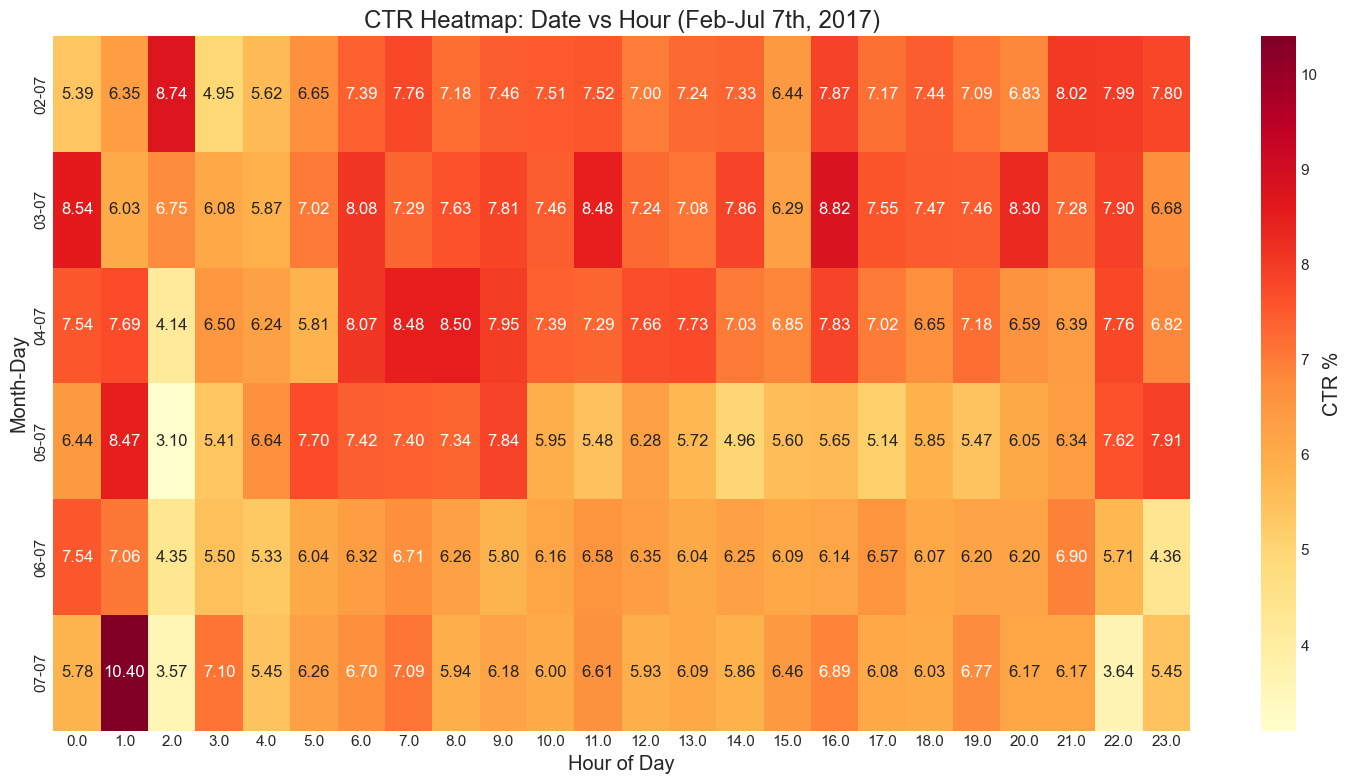


Peak Engagement Times:
02-07: Peak at hour 2 with CTR of 8.74%
03-07: Peak at hour 16 with CTR of 8.82%
04-07: Peak at hour 8 with CTR of 8.50%
05-07: Peak at hour 1 with CTR of 8.47%
06-07: Peak at hour 0 with CTR of 7.54%
07-07: Peak at hour 1 with CTR of 10.40%


In [52]:
# Create a month-day identifier for better grouping
filter_df['month_day'] = filter_df['DateTime'].dt.strftime('%m-%d')

# Verify our data distribution
print("Data distribution by month-day:")
print(filter_df.groupby('month_day')['is_click'].count())

# Create pivot table using month-day
hour_day_pivot = filter_df.pivot_table(
    values='is_click',
    index='month_day',
    columns='hour',
    aggfunc=lambda x: (sum(x)/len(x))*100
)

# Sort index by month-day
hour_day_pivot = hour_day_pivot.sort_index()

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(hour_day_pivot, 
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'CTR %'})

plt.title('CTR Heatmap: Date vs Hour (Feb-Jul 7th, 2017)')
plt.xlabel('Hour of Day')
plt.ylabel('Month-Day')
plt.tight_layout()
plt.show()

# Print peak engagement times
print("\nPeak Engagement Times:")
for month_day in sorted(hour_day_pivot.index):
    max_hour = hour_day_pivot.loc[month_day].idxmax()
    max_value = hour_day_pivot.loc[month_day, max_hour]
    print(f"{month_day}: Peak at hour {int(max_hour)} with CTR of {max_value:.2f}%")

In [53]:
# Calculate average CTR by hour across all days
avg_hourly_ctr = hour_day_pivot.mean()

print("\nTop 5 Best Performing Hours (Average across all days):")
print(avg_hourly_ctr.nlargest(5))

print("\nBottom 5 Performing Hours (Average across all days):")
print(avg_hourly_ctr.nsmallest(5))


Top 5 Best Performing Hours (Average across all days):
hour
1.0     7.667573
7.0     7.455863
6.0     7.328929
16.0    7.199177
9.0     7.173245
dtype: float64

Bottom 5 Performing Hours (Average across all days):
hour
2.0     5.108493
4.0     5.858249
3.0     5.920534
15.0    6.287985
23.0    6.504786
dtype: float64


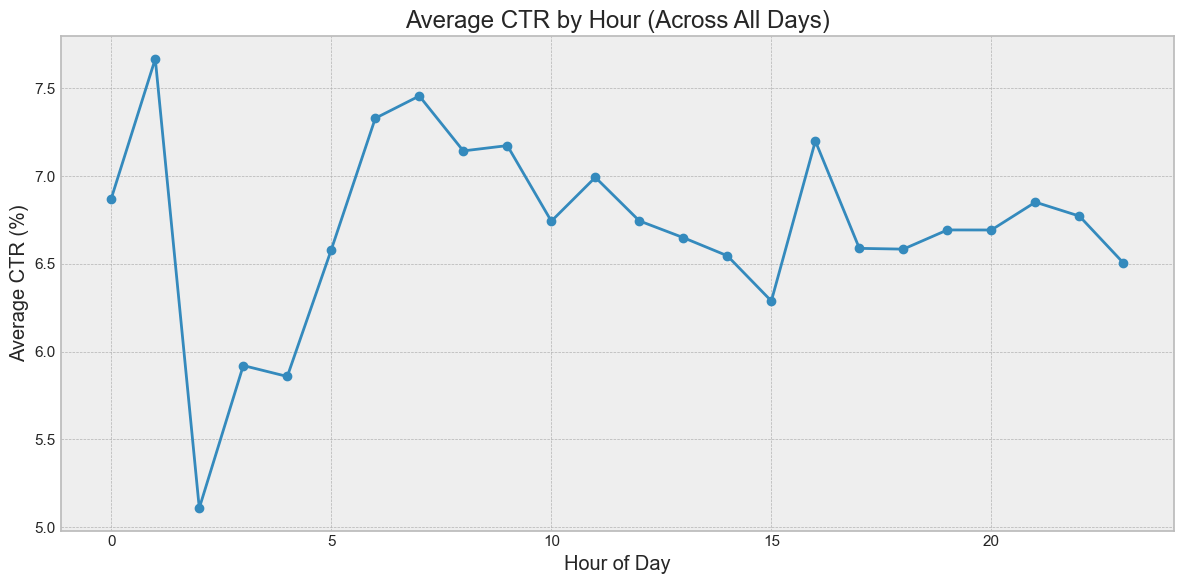

In [54]:
plt.figure(figsize=(12, 6))
avg_hourly_ctr.plot(kind='line', marker='o')
plt.title('Average CTR by Hour (Across All Days)')
plt.xlabel('Hour of Day')
plt.ylabel('Average CTR (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
print("Total number of unique products:", filter_df['product'].nunique())

# Overall product performance
product_performance = filter_df.groupby('product').agg({
    'is_click': ['count', 'sum']
}).reset_index()
product_performance.columns = ['product', 'impressions', 'clicks']
product_performance['overall_ctr'] = (product_performance['clicks'] / product_performance['impressions'] * 100).round(2)

# Show top performing products
print("\nTop 10 Products by Overall CTR:")
print(product_performance.nlargest(10, 'overall_ctr')[['product', 'overall_ctr', 'impressions', 'clicks']])

Total number of unique products: 10

Top 10 Products by Overall CTR:
   product  overall_ctr  impressions  clicks
9        9         9.49         7271   690.0
3        3         7.22        30970  2235.0
7        7         6.97        82256  5731.0
4        4         6.91        16203  1120.0
2        2         6.90       124080  8567.0
8        8         6.38        47830  3053.0
0        0         6.30        11588   730.0
1        1         5.57        16660   928.0
5        5         4.89         5257   257.0
6        6         4.56         7237   330.0


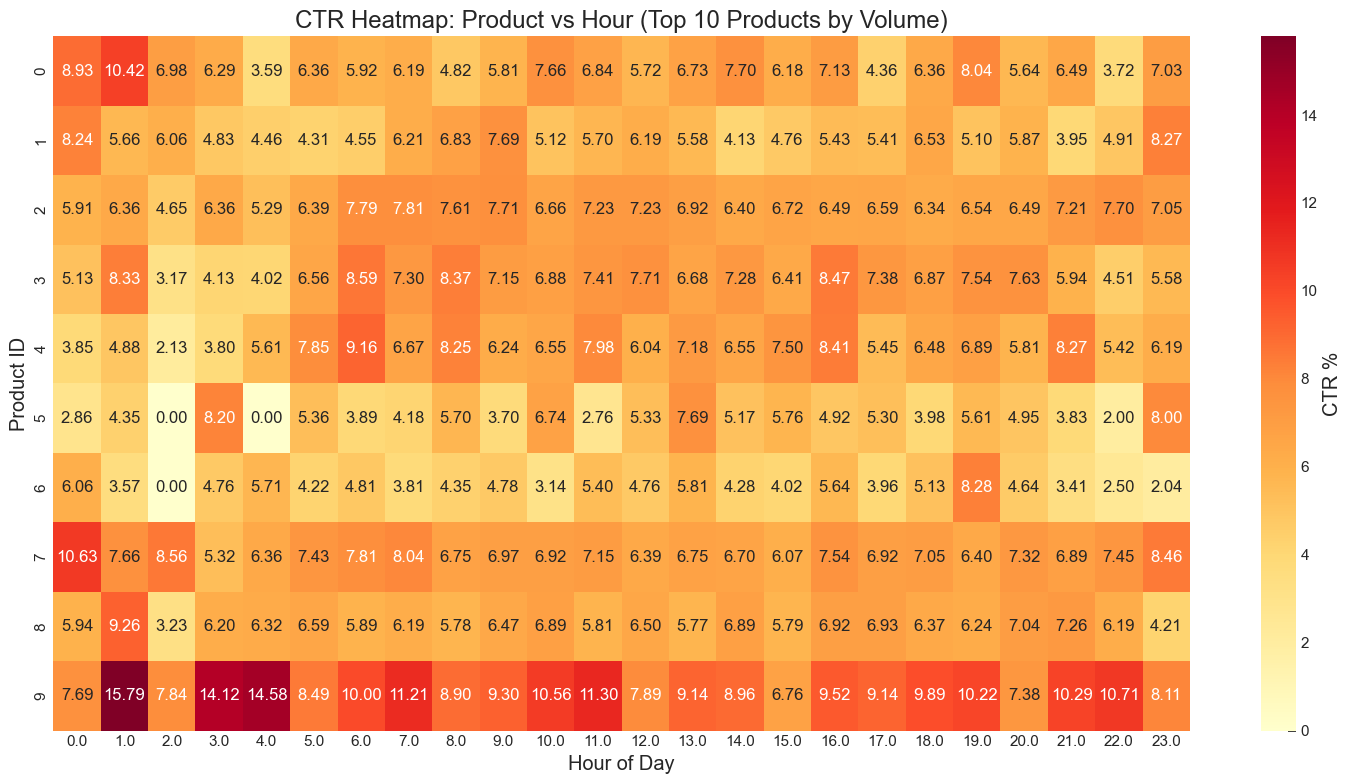

In [56]:
# Get top 10 products by impression volume (for statistical significance)
top_products = product_performance.nlargest(10, 'impressions')['product'].tolist()

# Create pivot table for product-hour CTR
product_hour_pivot = filter_df[filter_df['product'].isin(top_products)].pivot_table(
    values='is_click',
    index='product',
    columns='hour',
    aggfunc=lambda x: (sum(x)/len(x))*100
)

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(product_hour_pivot, 
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'CTR %'})

plt.title('CTR Heatmap: Product vs Hour (Top 10 Products by Volume)')
plt.xlabel('Hour of Day')
plt.ylabel('Product ID')
plt.tight_layout()
plt.show()

In [57]:
print("\nPeak Performance Hours by Product:")
for product in top_products:
    product_data = product_hour_pivot.loc[product]
    peak_hour = product_data.idxmax()
    peak_ctr = product_data.max()
    print(f"Product {product}: Peak CTR of {peak_ctr:.2f}% at hour {int(peak_hour)}")


Peak Performance Hours by Product:
Product 2: Peak CTR of 7.81% at hour 7
Product 7: Peak CTR of 10.63% at hour 0
Product 8: Peak CTR of 9.26% at hour 1
Product 3: Peak CTR of 8.59% at hour 6
Product 1: Peak CTR of 8.27% at hour 23
Product 4: Peak CTR of 9.16% at hour 6
Product 0: Peak CTR of 10.42% at hour 1
Product 9: Peak CTR of 15.79% at hour 1
Product 6: Peak CTR of 8.28% at hour 19
Product 5: Peak CTR of 8.20% at hour 3


In [58]:
# Define time periods
filter_df['time_period'] = pd.cut(filter_df['hour'], 
                                 bins=[0, 6, 12, 18, 23],
                                 labels=['Night (0-6)', 'Morning (6-12)', 
                                       'Afternoon (12-18)', 'Evening (18-23)'])

# Calculate CTR by product and time period
product_time_ctr = filter_df[filter_df['product'].isin(top_products)].pivot_table(
    values='is_click',
    index='product',
    columns='time_period',
    aggfunc=lambda x: (sum(x)/len(x))*100
)

print("\nCTR by Time Period for Top Products:")
print(product_time_ctr.round(2))


CTR by Time Period for Top Products:
time_period  Night (0-6)  Morning (6-12)  Afternoon (12-18)  Evening (18-23)
product                                                                     
0                   5.79            6.21               6.45             6.40
1                   4.56            6.24               5.36             5.29
2                   6.71            7.36               6.57             6.77
3                   7.07            7.46               7.16             7.06
4                   7.81            6.95               6.91             6.64
5                   4.22            4.77               5.33             4.82
6                   4.75            4.32               4.83             4.37
7                   7.12            7.01               6.82             6.98
8                   6.25            6.29               6.43             6.58
9                  10.80            9.88               8.86             9.16


In [59]:
filter_df['Time']=filter_df['DateTime'].dt.strftime('%H:00')
df_time = filter_df[['session_id','DateTime','Time','is_click']]
print(df_time)

        session_id            DateTime   Time  is_click
0          98528.0 2017-04-07 16:42:00  16:00       1.0
1         589714.0 2017-07-07 07:40:00  07:00       0.0
2         478652.0 2017-07-07 20:42:00  20:00       0.0
3          34536.0 2017-05-07 15:05:00  15:00       0.0
4          71863.0 2017-06-07 20:11:00  20:00       0.0
...            ...                 ...    ...       ...
370627    255315.0 2017-05-07 11:16:00  11:00       0.0
370628    198717.0 2017-06-07 16:32:00  16:00       0.0
370629     46593.0 2017-03-07 15:58:00  15:00       0.0
370630    317516.0 2017-03-07 19:34:00  19:00       0.0
370631     15927.0 2017-03-07 13:33:00  13:00       0.0

[349352 rows x 4 columns]


In [60]:
df_time_ctr = df_time.groupby(["Time"], as_index=False).agg(
    clicks=("is_click","sum"), 
    impressions=("is_click","count")
    )

df_time_ctr["ctr"] = df_time_ctr["clicks"]/df_time_ctr["impressions"]
print(df_time_ctr)

     Time  clicks  impressions       ctr
0   00:00   113.0         1644  0.068735
1   01:00    88.0         1163  0.075666
2   02:00    62.0         1172  0.052901
3   03:00   225.0         3742  0.060128
4   04:00   461.0         8003  0.057603
5   05:00   746.0        11311  0.065953
6   06:00  1154.0        15683  0.073583
7   07:00  1356.0        18396  0.073712
8   08:00  1369.0        19422  0.070487
9   09:00  1338.0        18826  0.071072
10  10:00  1547.0        23045  0.067130
11  11:00  1437.0        20608  0.069730
12  12:00  1284.0        18953  0.067747
13  13:00  1270.0        19025  0.066754
14  14:00  1283.0        19498  0.065802
15  15:00  1110.0        17723  0.062630
16  16:00  1147.0        16199  0.070807
17  17:00  1136.0        17288  0.065710
18  18:00  1342.0        20409  0.065755
19  19:00  1637.0        24612  0.066512
20  20:00  1797.0        26751  0.067175
21  21:00  1110.0        16210  0.068476
22  22:00   426.0         6470  0.065842
23  23:00   198.

<Axes: title={'center': 'CTR by hour'}, xlabel='Time'>

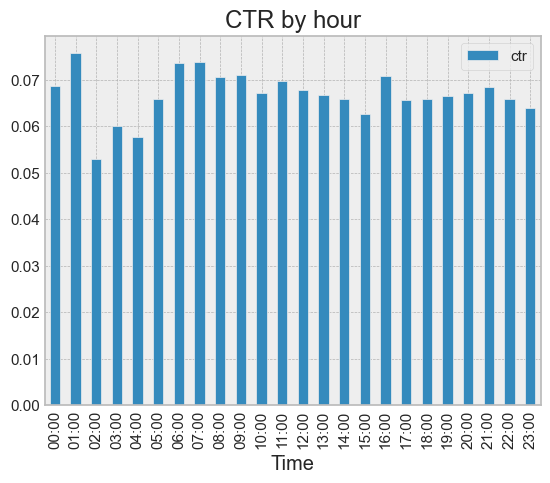

In [61]:
df_time_ctr.plot(kind="bar", x="Time", y="ctr", title="CTR by hour")

In [62]:
d = filter_df.copy()
d.set_index('date', inplace=True)
d.sort_index(inplace=True)

In [63]:
d.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_number,month_day,time_period,Time
date,,,,,,,,,,,,,,,,,,,,,
2017-02-07,157140.0,2017-02-07 21:07:00,12005.0,7,105960.0,11085.0,5.0,270915.0,3.0,1,...,3.0,4.0,0.0,0.0,21.0,Tuesday,7.0,02-07,Evening (18-23),21:00
2017-02-07,487716.0,2017-02-07 13:35:00,686819.0,7,359520.0,13787.0,3.0,NaN,9.0,0,...,3.0,3.0,1.0,0.0,13.0,Tuesday,7.0,02-07,Afternoon (12-18),13:00
2017-02-07,118334.0,2017-02-07 20:10:00,846080.0,7,105960.0,11085.0,4.0,NaN,10.0,0,...,3.0,4.0,1.0,0.0,20.0,Tuesday,7.0,02-07,Evening (18-23),20:00
2017-02-07,484754.0,2017-02-07 08:16:00,1102319.0,3,98970.0,6970.0,2.0,NaN,3.0,1,...,3.0,2.0,1.0,0.0,8.0,Tuesday,7.0,02-07,Morning (6-12),08:00
2017-02-07,478193.0,2017-02-07 10:22:00,861186.0,7,359520.0,13787.0,4.0,NaN,3.0,1,...,3.0,1.0,0.0,0.0,10.0,Tuesday,7.0,02-07,Morning (6-12),10:00


In [64]:
daily = d.groupby('date').size()
daily

date
2017-02-07    59239
2017-03-07    61299
2017-04-07    55026
2017-05-07    60971
2017-06-07    58760
2017-07-07    53952
dtype: int64

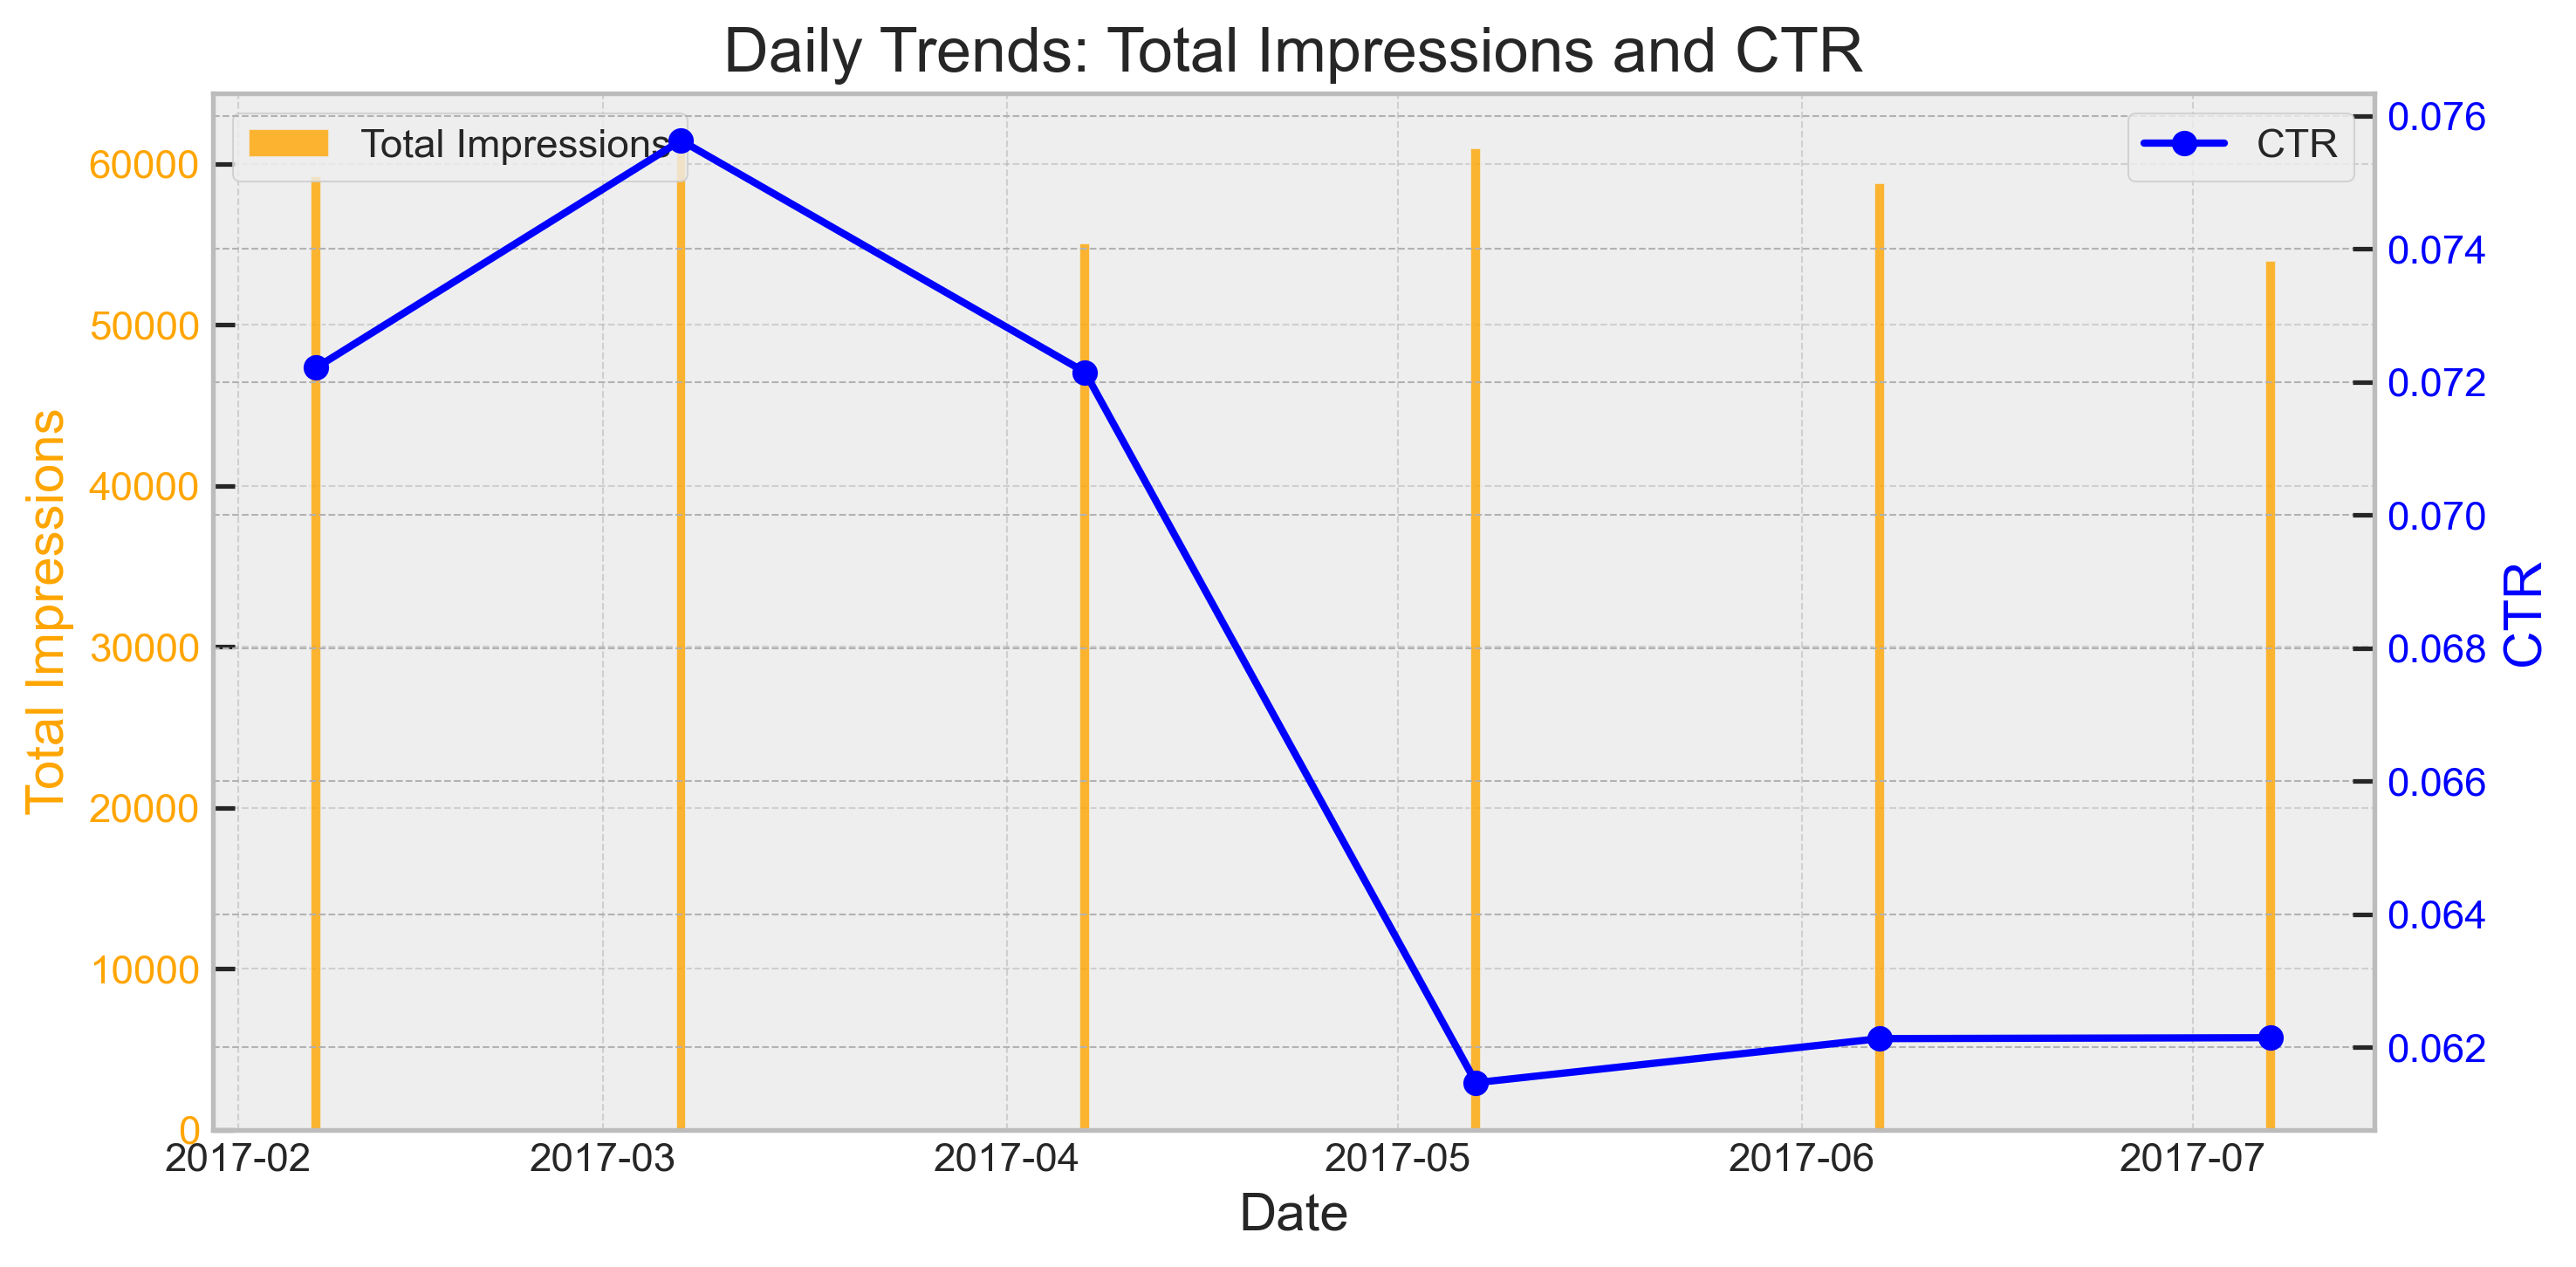

In [65]:
daily_ctr = d.groupby('date')["is_click"].mean()  # Mean CTR per day

fig, ax1 = plt.subplots(figsize=(10, 5), dpi=300)

# Bar chart for total impressions on the primary y-axis
ax1.bar(daily.index, daily, color='orange', alpha=0.8, label='Total Impressions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Impressions', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)

# Line plot for CTR on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_ctr.index, daily_ctr, linewidth=2, color='blue', marker='o', label='CTR')
ax2.set_ylabel('CTR', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.title('Daily Trends: Total Impressions and CTR')
plt.tight_layout()
plt.show()


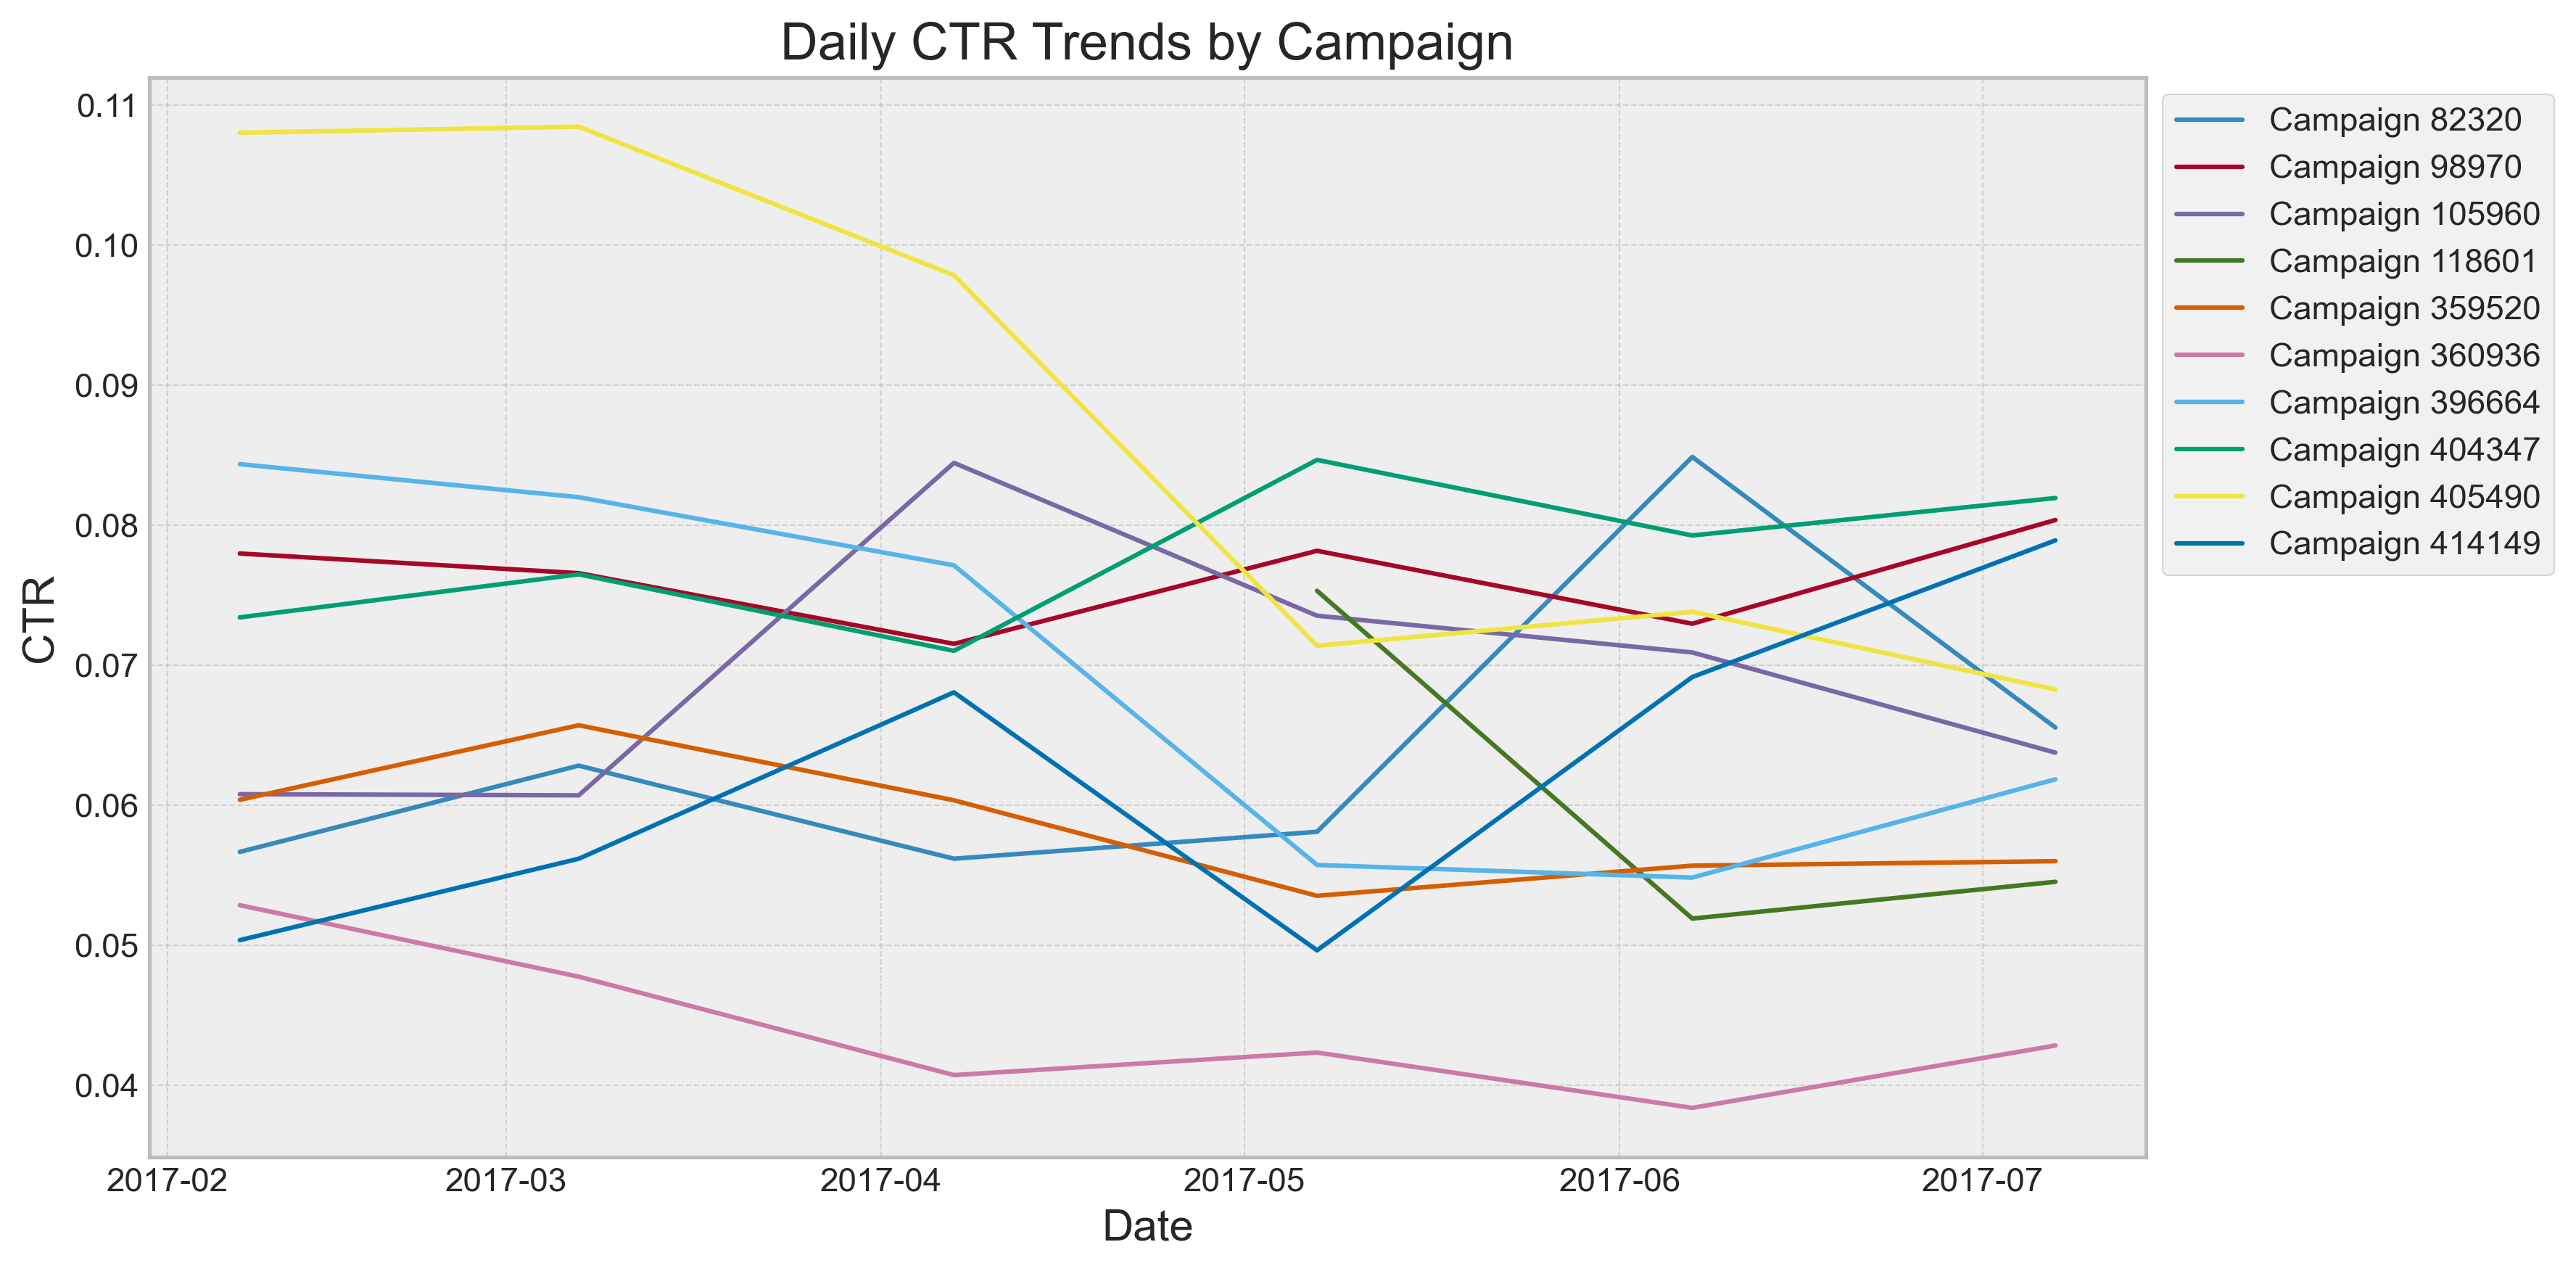

In [66]:
# Group by campaign_id and date to calculate daily CTR
daily_ctr_campaign = (
    d.groupby(['campaign_id', 'date'])['is_click']
    .mean()
    .reset_index()
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Plot CTR trends for each campaign
for campaign_id in daily_ctr_campaign['campaign_id'].unique():
    campaign_data = daily_ctr_campaign[daily_ctr_campaign['campaign_id'] == campaign_id]
    ax.plot(
        campaign_data['date'],  # Use 'date' for x-axis
        campaign_data['is_click'],  # CTR values
        label=f'Campaign {int(campaign_id)}',
        linewidth=1.5
    )

ax.set_xlabel('Date')
ax.set_ylabel('CTR')
ax.set_title('Daily CTR Trends by Campaign')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside plot
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [67]:
# Distribution of clicks within each month
daily_distributions = d.groupby('date')["is_click"].describe()
print(daily_distributions)

              count      mean       std  min  25%  50%  75%  max
date                                                            
2017-02-07  59239.0  0.072216  0.258847  0.0  0.0  0.0  0.0  1.0
2017-03-07  61299.0  0.075629  0.264406  0.0  0.0  0.0  0.0  1.0
2017-04-07  55026.0  0.072148  0.258735  0.0  0.0  0.0  0.0  1.0
2017-05-07  60971.0  0.061472  0.240196  0.0  0.0  0.0  0.0  1.0
2017-06-07  58760.0  0.062134  0.241401  0.0  0.0  0.0  0.0  1.0
2017-07-07  53952.0  0.062148  0.241426  0.0  0.0  0.0  0.0  1.0


#### Investigate session-level attributes (user_depth) to see if higher engagement levels correlate with increased CTR.


In [68]:
filter_df.head(2)

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,city_development_index,var_1,is_click,date,hour,day_of_week,day_number,month_day,time_period,Time
0,98528.0,2017-04-07 16:42:00,7716.0,2,405490.0,60305.0,3.0,NaN,3.0,1,...,NaN,1.0,1.0,2017-04-07,16.0,Friday,7.0,04-07,Afternoon (12-18),16:00
1,589714.0,2017-07-07 07:40:00,1035283.0,8,118601.0,28529.0,4.0,82527.0,10.0,0,...,3.0,1.0,0.0,2017-07-07,7.0,Friday,7.0,07-07,Morning (6-12),07:00


In [69]:
# Aggregate data by user_depth
user_depth_analysis = filter_df.groupby('user_depth').agg(
    total_clicks=('is_click', 'sum'),
    total_impressions=('is_click', 'count')
)
user_depth_analysis['ctr'] = user_depth_analysis['total_clicks'] / user_depth_analysis['total_impressions']

user_depth_analysis

,total_clicks,total_impressions,ctr
user_depth,,,
1.0,677.0,9336,0.072515
2.0,1528.0,23881,0.063984
3.0,21436.0,316135,0.067806


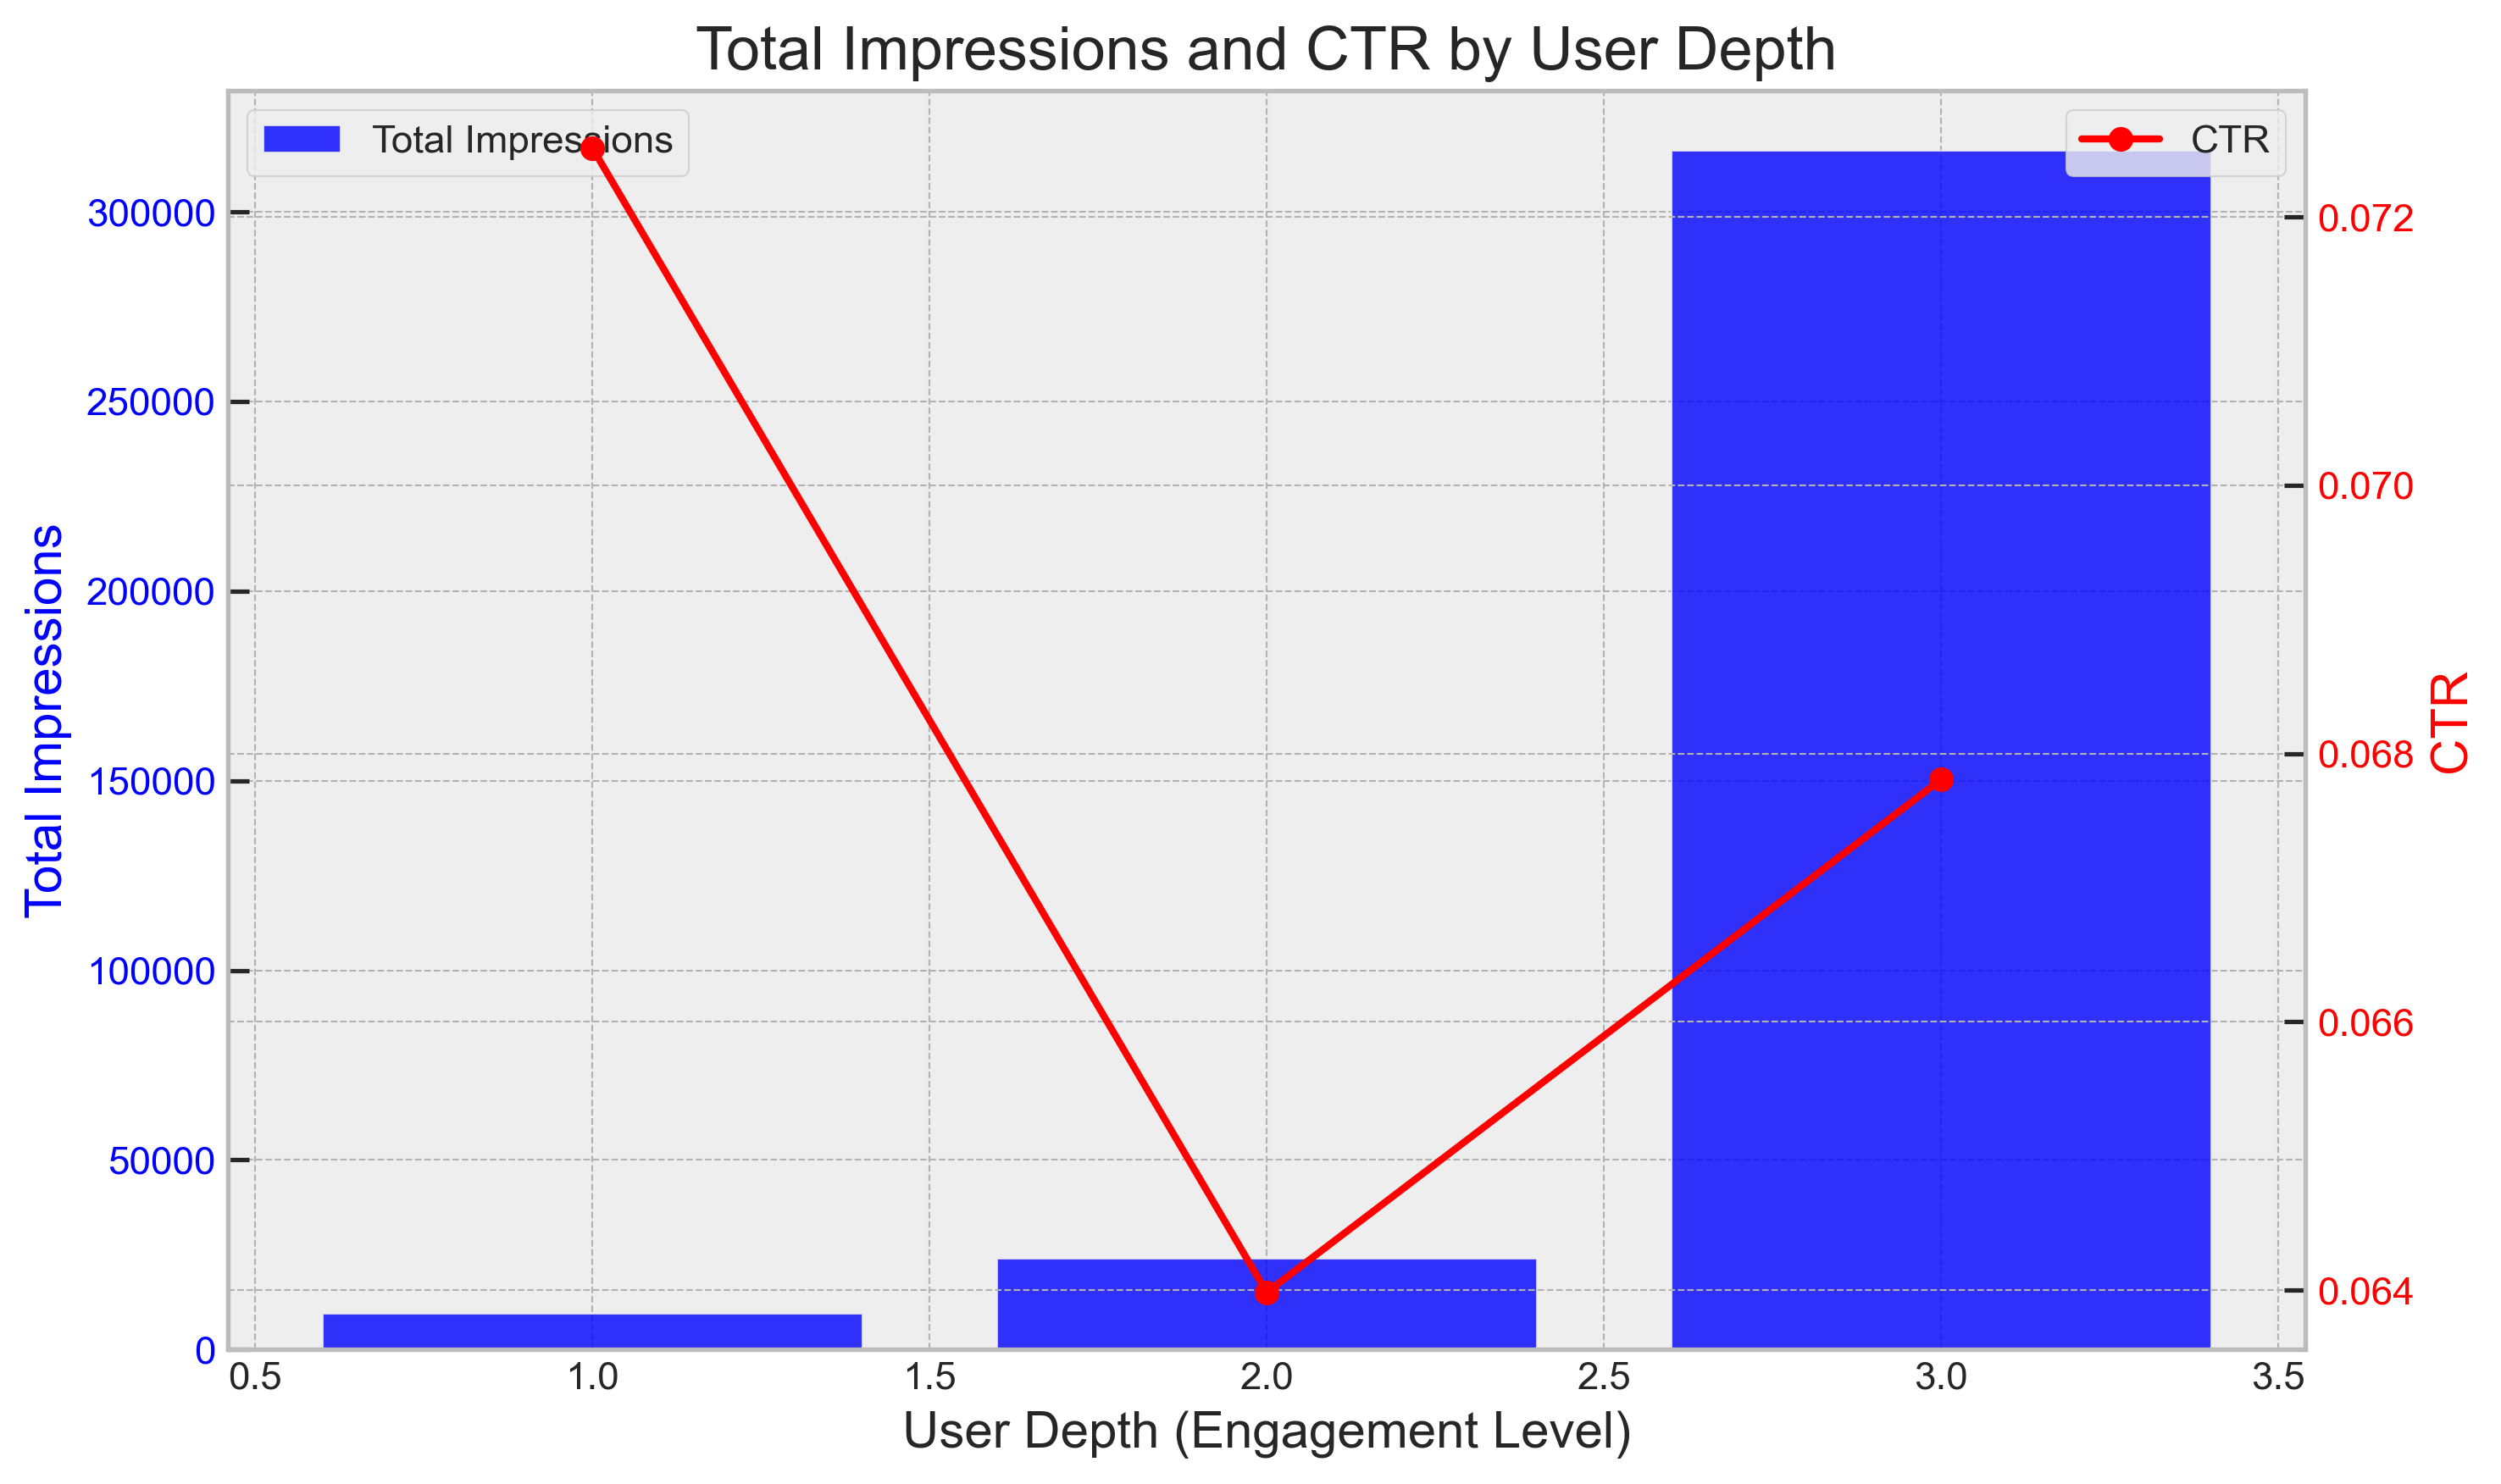

In [70]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)

# Bar plot for total impressions
ax1.bar(user_depth_analysis.index, user_depth_analysis['total_impressions'], color='blue', alpha=0.8, label='Total Impressions')
ax1.set_xlabel('User Depth (Engagement Level)')
ax1.set_ylabel('Total Impressions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Line plot for CTR
ax2 = ax1.twinx()
ax2.plot(user_depth_analysis.index, user_depth_analysis['ctr'], color='red', marker='o', linewidth=2, label='CTR')
ax2.set_ylabel('CTR', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Total Impressions and CTR by User Depth')
plt.tight_layout()
plt.show()

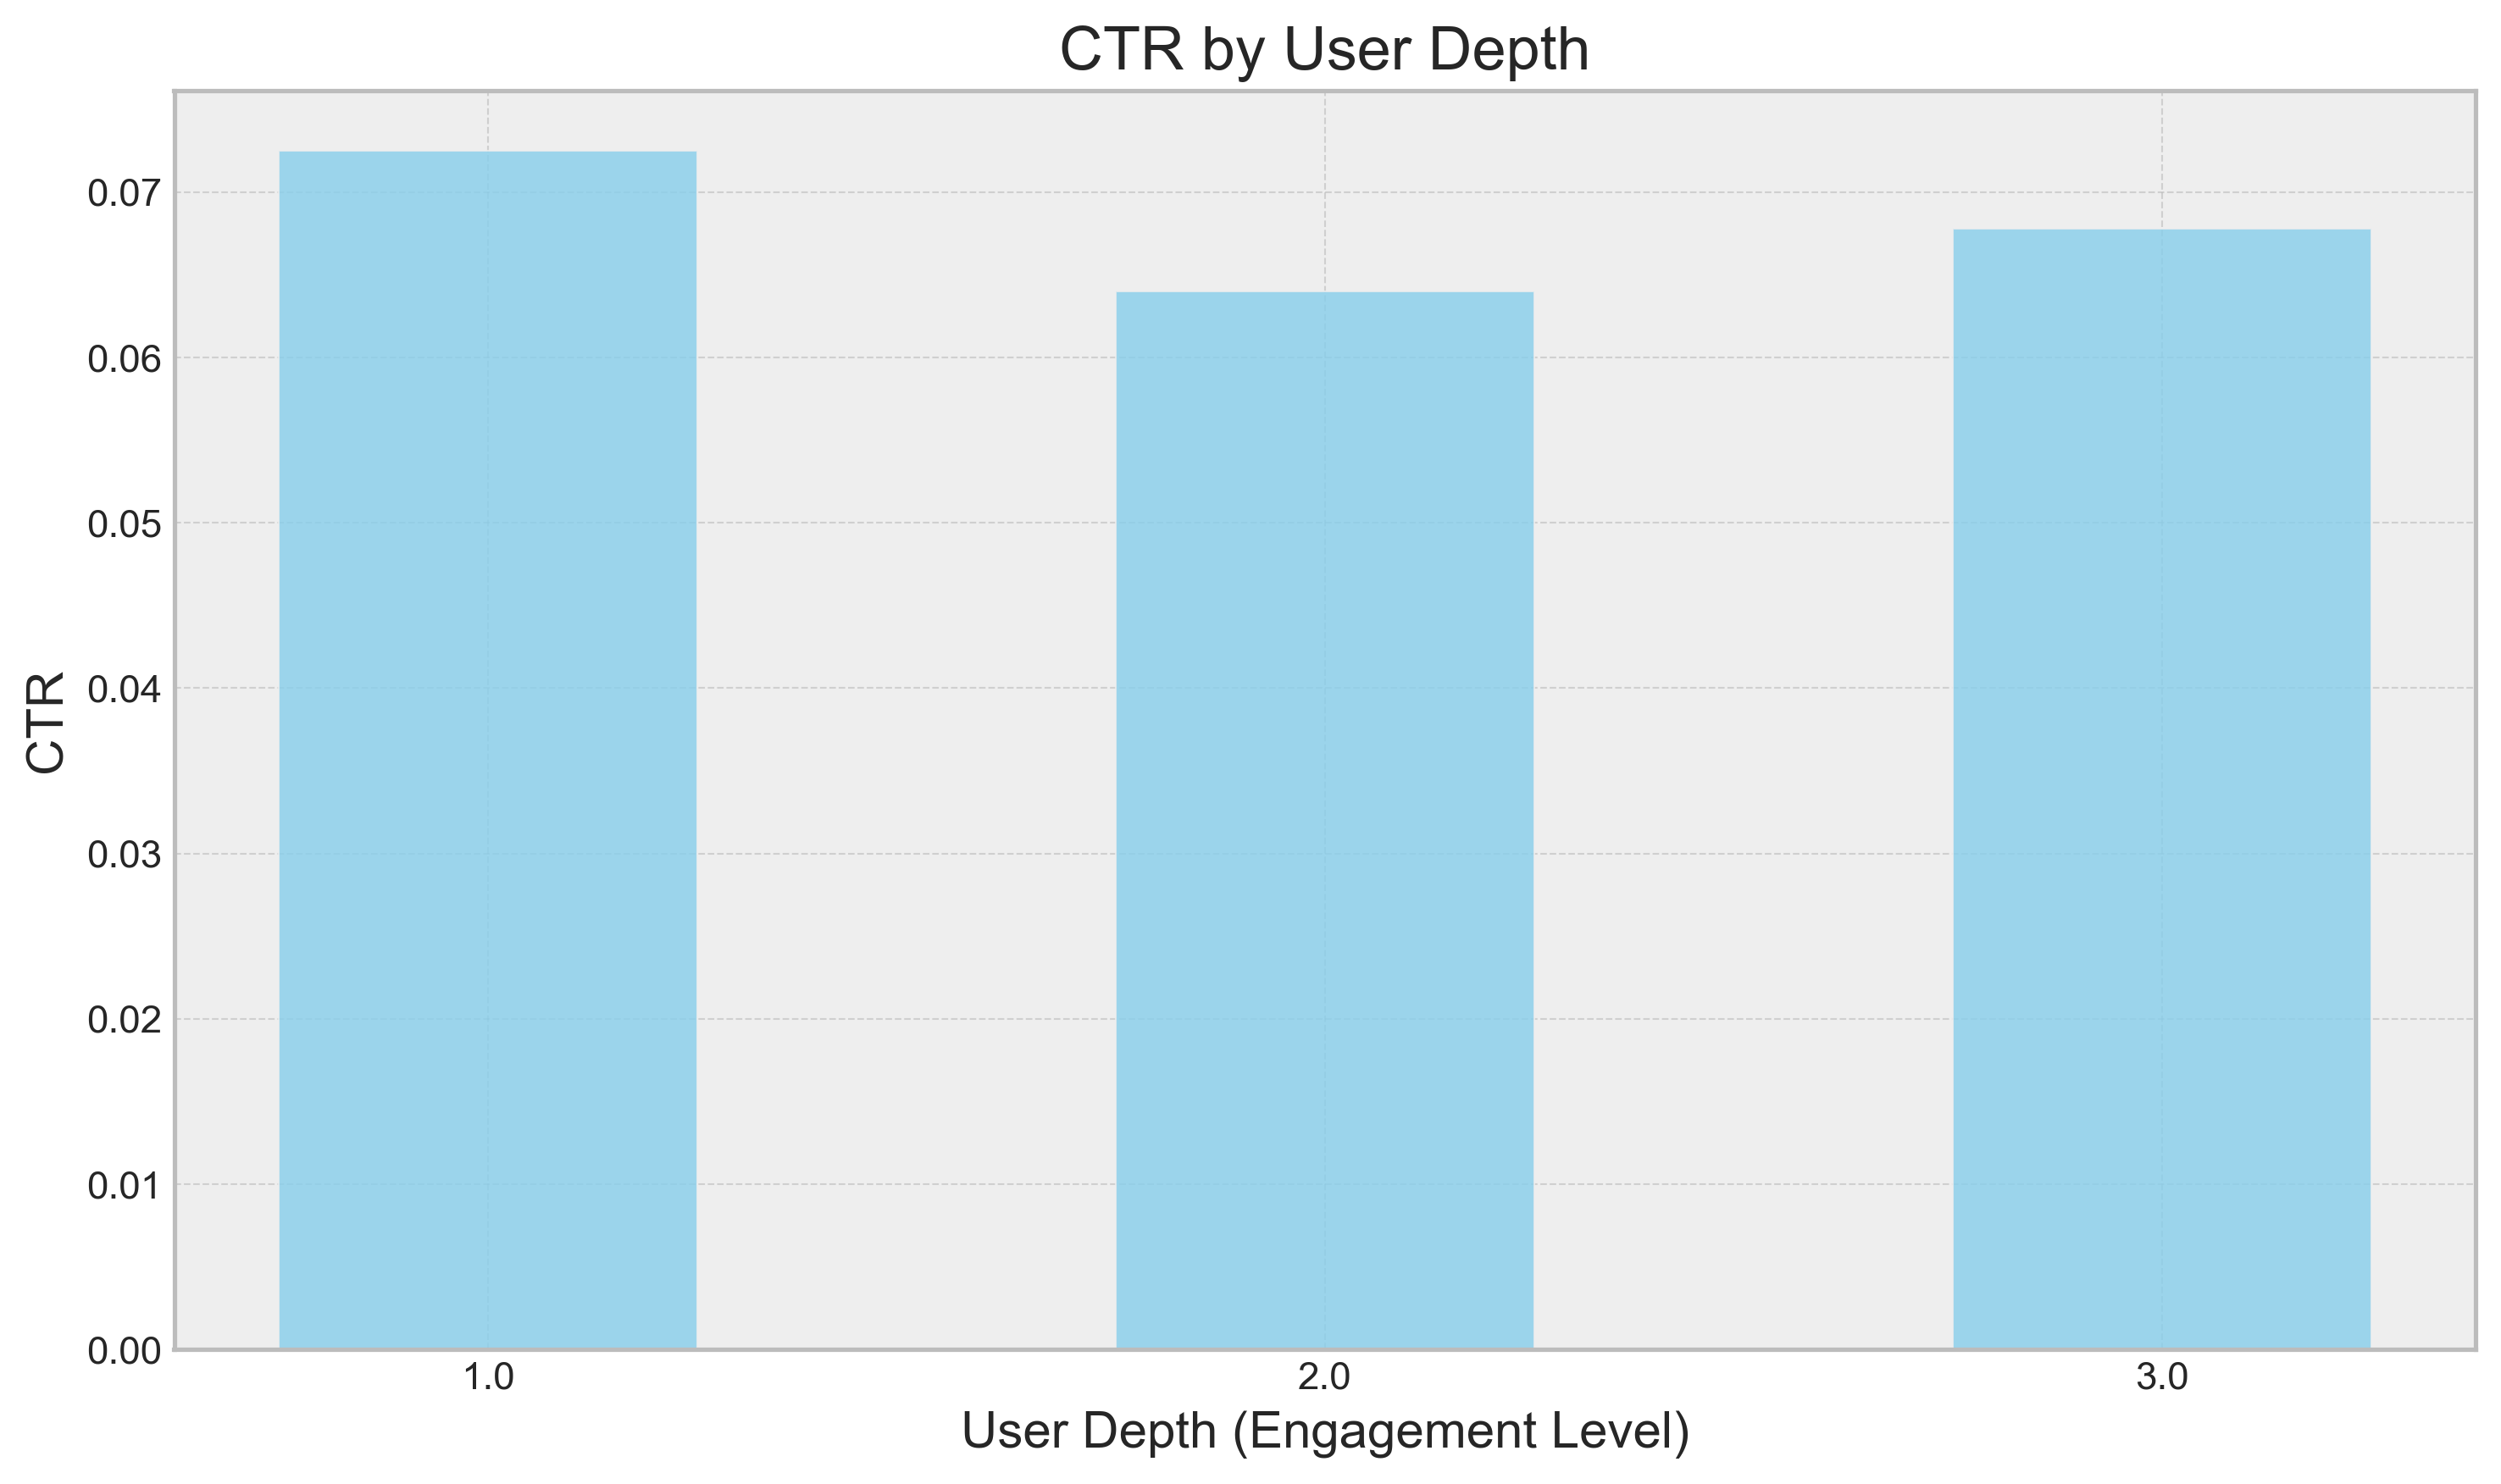

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=300)

# Bar chart for CTR
plt.bar(user_depth_analysis.index.astype(str), user_depth_analysis['ctr'], color='skyblue', alpha=0.8, width=0.5)
plt.xlabel('User Depth (Engagement Level)')
plt.ylabel('CTR')
plt.title('CTR by User Depth')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

#### Analyze var_1

var_1 Unique Values: [ 1.  0. nan]

Distribution of var_1:
var_1
0.0    199905
1.0    149362
Name: count, dtype: int64


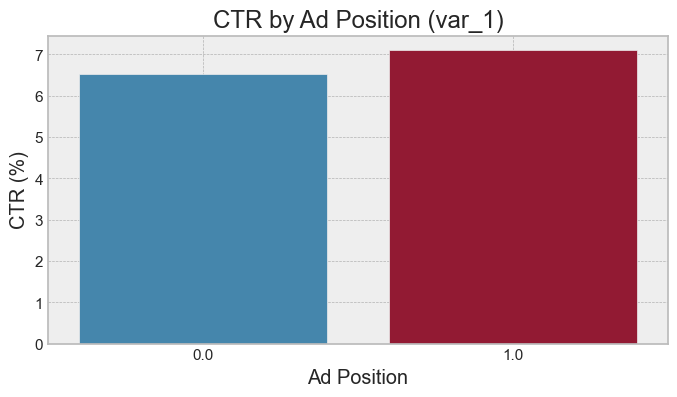


CTR by Position:
   position  impressions   clicks   ctr
1       1.0       149362  10604.0  7.10
0       0.0       199905  13033.0  6.52


In [72]:
# Basic stats of var_1
print("var_1 Unique Values:", filter_df['var_1'].unique())
print("\nDistribution of var_1:")
print(filter_df['var_1'].value_counts())

# Calculate overall CTR by var_1 position
position_ctr = filter_df.groupby('var_1').agg({
    'is_click': ['count', 'sum']
}).reset_index()
position_ctr.columns = ['position', 'impressions', 'clicks']
position_ctr['ctr'] = (position_ctr['clicks'] / position_ctr['impressions'] * 100).round(2)

# Visualize CTR by position
plt.figure(figsize=(8, 4))
sns.barplot(data=position_ctr, x='position', y='ctr')
plt.title('CTR by Ad Position (var_1)')
plt.xlabel('Ad Position')
plt.ylabel('CTR (%)')
plt.grid(True)
plt.show()

print("\nCTR by Position:")
print(position_ctr.sort_values('ctr', ascending=False))

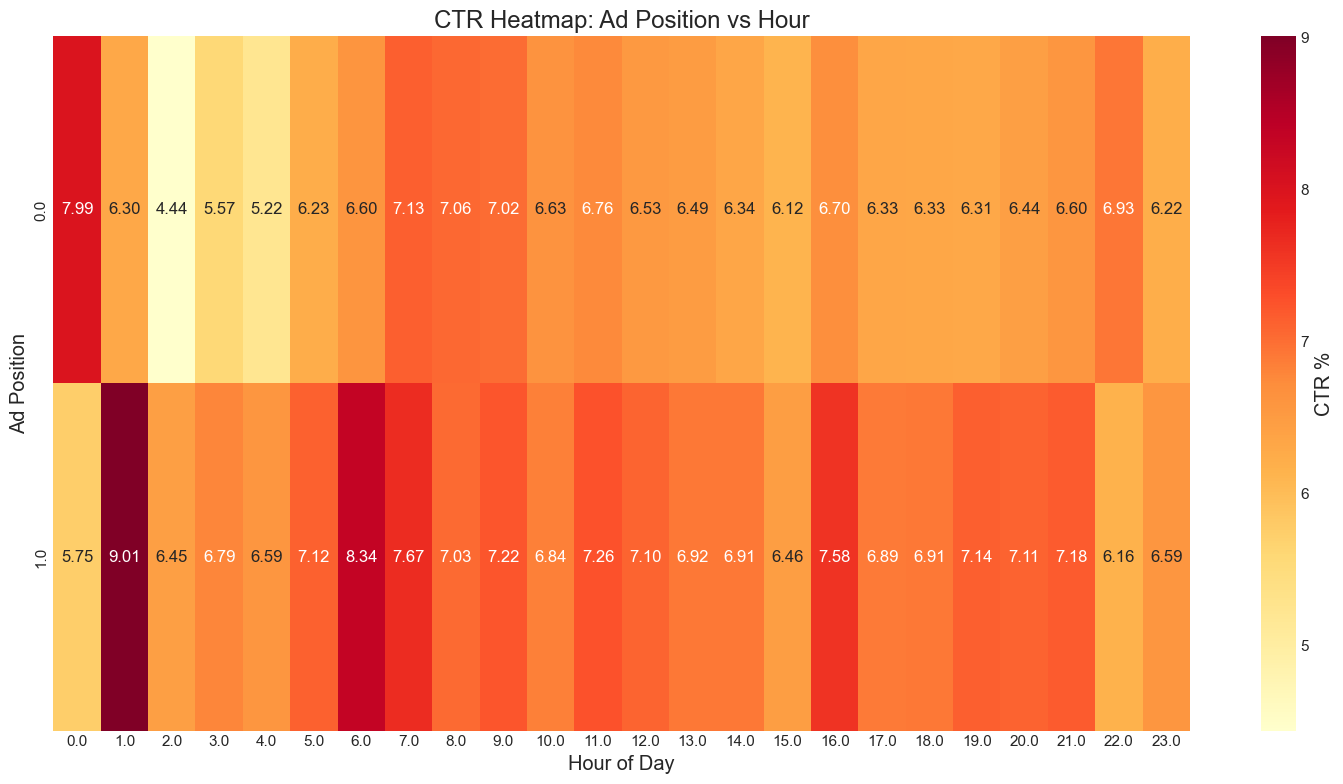

In [73]:
# Create position-hour heatmap
position_hour_pivot = filter_df.pivot_table(
    values='is_click',
    index='var_1',
    columns='hour',
    aggfunc=lambda x: (sum(x)/len(x))*100
)

plt.figure(figsize=(15, 8))
sns.heatmap(position_hour_pivot, 
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'CTR %'})
plt.title('CTR Heatmap: Ad Position vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Ad Position')
plt.tight_layout()
plt.show()


CTR by Position for Top Products:
var_1     0.0   1.0
product            
1        5.47  5.71
2        6.71  7.16
3        6.82  7.65
7        6.67  7.38
8        6.28  6.56


<Figure size 1200x600 with 0 Axes>

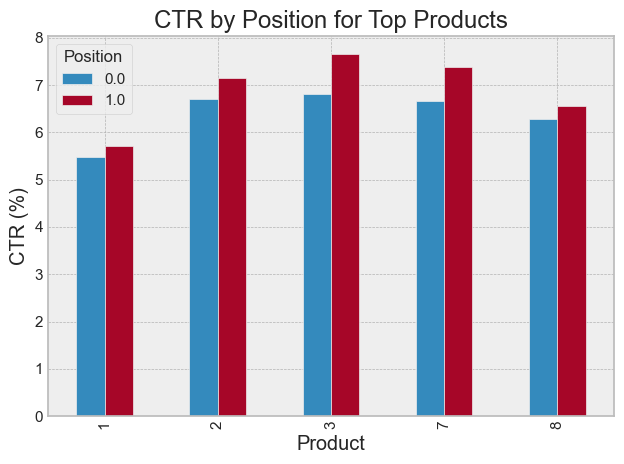

In [74]:
# Get top 5 products by volume
top_products = filter_df.groupby('product')['is_click'].count().nlargest(5).index

# Calculate CTR by position for top products
product_position_ctr = filter_df[filter_df['product'].isin(top_products)].pivot_table(
    values='is_click',
    index='product',
    columns='var_1',
    aggfunc=lambda x: (sum(x)/len(x))*100
).round(2)

print("\nCTR by Position for Top Products:")
print(product_position_ctr)

# Visualize
plt.figure(figsize=(12, 6))
product_position_ctr.plot(kind='bar')
plt.title('CTR by Position for Top Products')
plt.xlabel('Product')
plt.ylabel('CTR (%)')
plt.legend(title='Position')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
# Perform chi-square test to check if position significantly affects CTR
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(filter_df['var_1'], filter_df['is_click'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nStatistical Test Results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.10f}")
print("Is position significant? ", "Yes" if p_value < 0.05 else "No")


Statistical Test Results:
Chi-square statistic: 45.48
p-value: 0.0000000000
Is position significant?  Yes


In [76]:
# Get top webpages by impression volume
webpage_stats = filter_df.groupby('webpage_id').agg({
    'is_click': ['count', 'sum']
}).reset_index()
webpage_stats.columns = ['webpage_id', 'impressions', 'clicks']
webpage_stats['ctr'] = (webpage_stats['clicks'] / webpage_stats['impressions'] * 100).round(2)

# Filter top webpages (e.g., those with >1000 impressions for statistical significance)
top_webpages = webpage_stats[webpage_stats['impressions'] > 1000].sort_values('impressions', ascending=False)

print("Top 10 Webpages by Volume:")
print(top_webpages.head(10))

Top 10 Webpages by Volume:
   webpage_id  impressions  clicks   ctr
3     13787.0       121291  6615.0  5.45
8     60305.0        72395  6597.0  9.11
4     28529.0        27276  1457.0  5.34
1      6970.0        26576  2028.0  7.63
5     45962.0        22053  1308.0  5.93
7     53587.0        21512  1667.0  7.75
0      1734.0        20463  1296.0  6.33
2     11085.0        19494  1328.0  6.81
6     51181.0        18195  1336.0  7.34


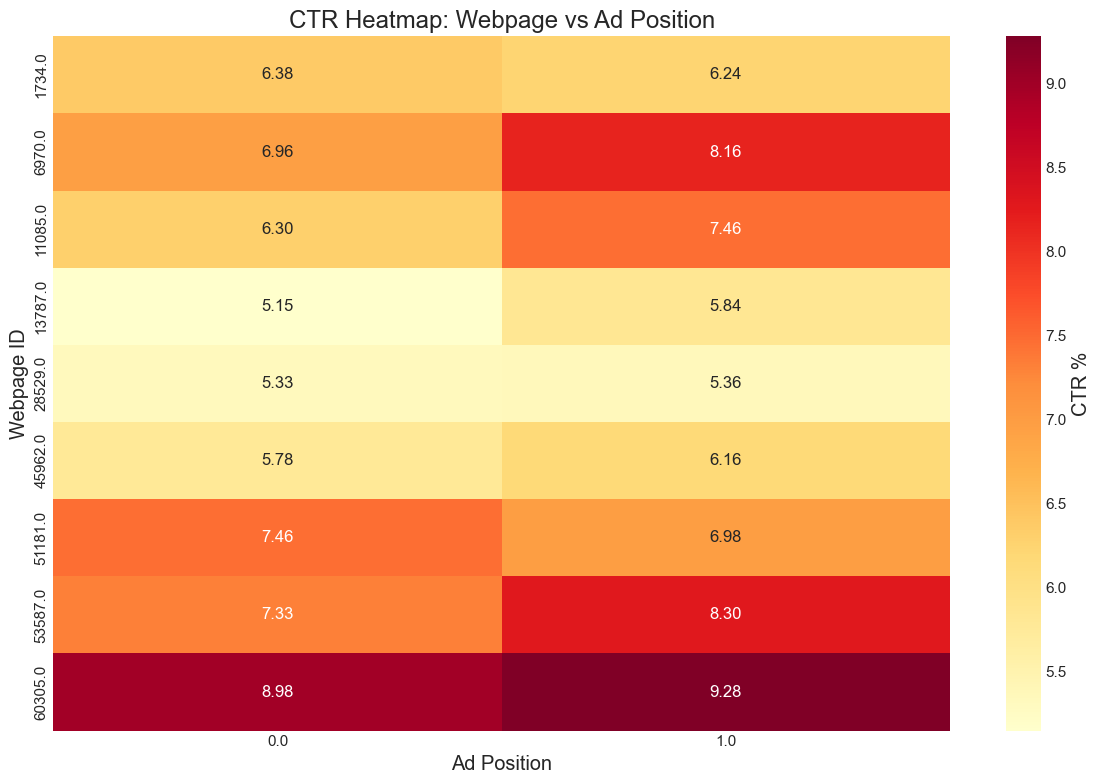

In [77]:
# Create webpage-position CTR pivot table
webpage_position_pivot = filter_df[filter_df['webpage_id'].isin(top_webpages['webpage_id'].head(10))].pivot_table(
    values='is_click',
    index='webpage_id',
    columns='var_1',
    aggfunc=lambda x: (sum(x)/len(x))*100
)

plt.figure(figsize=(12, 8))
sns.heatmap(webpage_position_pivot, 
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'CTR %'})
plt.title('CTR Heatmap: Webpage vs Ad Position')
plt.xlabel('Ad Position')
plt.ylabel('Webpage ID')
plt.tight_layout()
plt.show()

In [78]:
print("\nBest Performing Positions by Webpage:")
for webpage in webpage_position_pivot.index:
    best_position = webpage_position_pivot.loc[webpage].idxmax()
    best_ctr = webpage_position_pivot.loc[webpage].max()
    print(f"Webpage {webpage}: Best CTR of {best_ctr:.2f}% at position {best_position}")


Best Performing Positions by Webpage:
Webpage 1734.0: Best CTR of 6.38% at position 0.0
Webpage 6970.0: Best CTR of 8.16% at position 1.0
Webpage 11085.0: Best CTR of 7.46% at position 1.0
Webpage 13787.0: Best CTR of 5.84% at position 1.0
Webpage 28529.0: Best CTR of 5.36% at position 1.0
Webpage 45962.0: Best CTR of 6.16% at position 1.0
Webpage 51181.0: Best CTR of 7.46% at position 0.0
Webpage 53587.0: Best CTR of 8.30% at position 1.0
Webpage 60305.0: Best CTR of 9.28% at position 1.0


In [79]:
# Calculate position rank within each webpage
position_ranks = webpage_position_pivot.rank(axis=1, ascending=False)

print("\nAverage Position Rank Across Webpages:")
print(position_ranks.mean().sort_values())

# Calculate coefficient of variation to measure consistency
position_cv = webpage_position_pivot.std() / webpage_position_pivot.mean() * 100

print("\nPosition Performance Consistency (lower CV % = more consistent):")
print(position_cv.sort_values())


Average Position Rank Across Webpages:
var_1
1.0    1.222222
0.0    1.777778
dtype: float64

Position Performance Consistency (lower CV % = more consistent):
var_1
0.0    18.122243
1.0    18.488240
dtype: float64


In [80]:
from scipy.stats import chi2_contingency

print("\nStatistical Significance of Position Effect by Webpage:")
for webpage in top_webpages['webpage_id'].head(10):
    webpage_data = filter_df[filter_df['webpage_id'] == webpage]
    contingency = pd.crosstab(webpage_data['var_1'], webpage_data['is_click'])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    print(f"Webpage {webpage}: p-value = {p_value:.10f}")


Statistical Significance of Position Effect by Webpage:
Webpage 13787.0: p-value = 0.0000001776
Webpage 60305.0: p-value = 0.1583116478
Webpage 28529.0: p-value = 0.9519857315
Webpage 6970.0: p-value = 0.0002575690
Webpage 45962.0: p-value = 0.2590948494
Webpage 53587.0: p-value = 0.0092332615
Webpage 1734.0: p-value = 0.7275985085
Webpage 11085.0: p-value = 0.0015420151
Webpage 51181.0: p-value = 0.2976691447


CTR by Position and Gender:
gender     0     1
var_1             
0.0     6.19  6.57
1.0     6.83  7.13


<Figure size 1000x600 with 0 Axes>

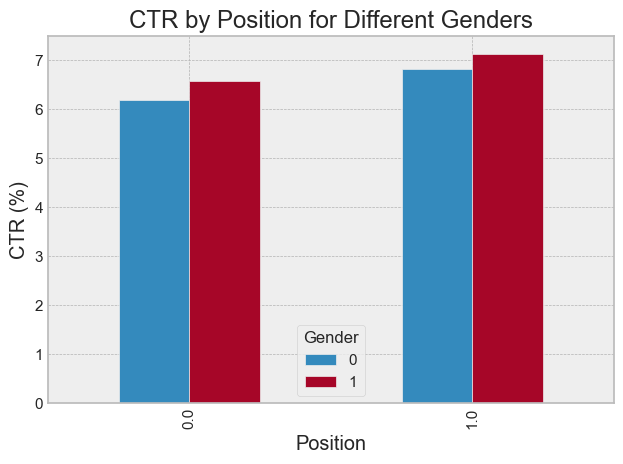

In [81]:
# Create position-gender CTR analysis
gender_position_pivot = filter_df.pivot_table(
    values='is_click',
    index='var_1',
    columns='gender',
    aggfunc=lambda x: (sum(x)/len(x))*100
).round(2)

print("CTR by Position and Gender:")
print(gender_position_pivot)

# Visualize
plt.figure(figsize=(10, 6))
gender_position_pivot.plot(kind='bar')
plt.title('CTR by Position for Different Genders')
plt.xlabel('Position')
plt.ylabel('CTR (%)')
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()


Unique Age Levels: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

CTR by Position and Age Level:
age_level    0.0   1.0   2.0   3.0   4.0   5.0   6.0
var_1                                               
0.0        10.87  7.43  6.82  5.97  5.20  7.57  7.26
1.0        10.00  7.47  7.61  6.94  6.45  7.27  9.50


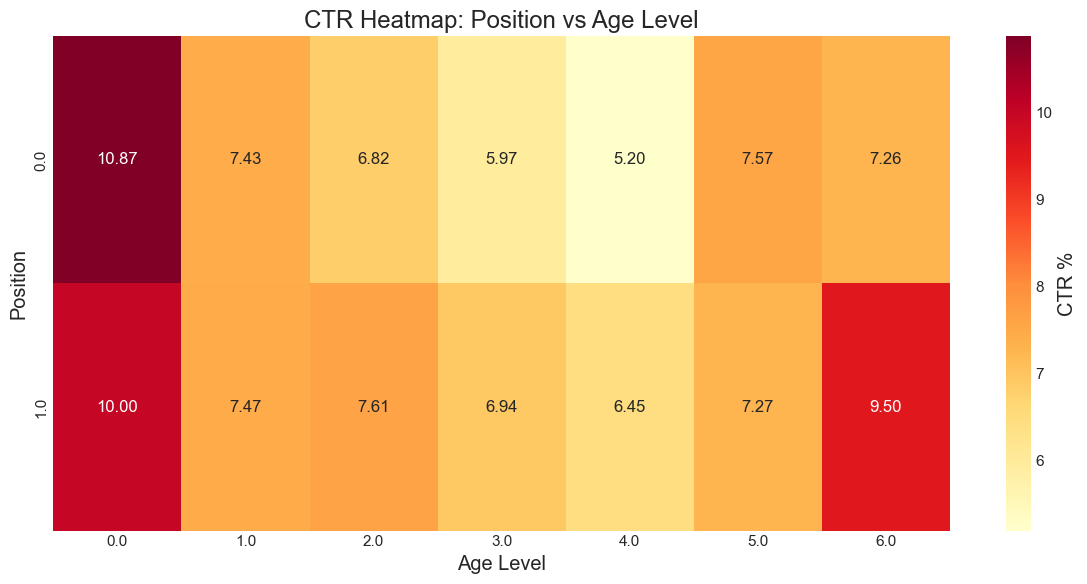

In [82]:
# Check age level distribution first
print("\nUnique Age Levels:", sorted(filter_df['age_level'].unique()))

# Create position-age CTR analysis
age_position_pivot = filter_df.pivot_table(
    values='is_click',
    index='var_1',
    columns='age_level',
    aggfunc=lambda x: (sum(x)/len(x))*100
).round(2)

print("\nCTR by Position and Age Level:")
print(age_position_pivot)

# Visualize
plt.figure(figsize=(12, 6))
sns.heatmap(age_position_pivot, 
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'CTR %'})
plt.title('CTR Heatmap: Position vs Age Level')
plt.xlabel('Age Level')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

In [83]:
# Best positions by gender
print("\nBest Performing Positions by Gender:")
for gender in gender_position_pivot.columns:
    best_pos = gender_position_pivot[gender].idxmax()
    best_ctr = gender_position_pivot[gender].max()
    print(f"Gender {gender}: Best CTR of {best_ctr:.2f}% at position {best_pos}")

# Best positions by age level
print("\nBest Performing Positions by Age Level:")
for age in age_position_pivot.columns:
    best_pos = age_position_pivot[age].idxmax()
    best_ctr = age_position_pivot[age].max()
    print(f"Age Level {age}: Best CTR of {best_ctr:.2f}% at position {best_pos}")


Best Performing Positions by Gender:
Gender 0: Best CTR of 6.83% at position 1.0
Gender 1: Best CTR of 7.13% at position 1.0

Best Performing Positions by Age Level:
Age Level 0.0: Best CTR of 10.87% at position 0.0
Age Level 1.0: Best CTR of 7.47% at position 1.0
Age Level 2.0: Best CTR of 7.61% at position 1.0
Age Level 3.0: Best CTR of 6.94% at position 1.0
Age Level 4.0: Best CTR of 6.45% at position 1.0
Age Level 5.0: Best CTR of 7.57% at position 0.0
Age Level 6.0: Best CTR of 9.50% at position 1.0


In [84]:
# Create a combined demographic analysis for top performing positions
top_positions = filter_df['var_1'].value_counts().head(3).index

for pos in top_positions:
    pos_data = filter_df[filter_df['var_1'] == pos].pivot_table(
        values='is_click',
        index='gender',
        columns='age_level',
        aggfunc=lambda x: (sum(x)/len(x))*100
    ).round(2)
    
    print(f"\nPosition {pos} - CTR by Gender and Age Level:")
    print(pos_data)


Position 0.0 - CTR by Gender and Age Level:
age_level    0.0   1.0   2.0   3.0   4.0   5.0   6.0
gender                                              
0           5.56  7.50  6.32  5.72  5.05  8.00  8.40
1          12.16  7.42  6.85  6.01  5.25  7.39  6.64

Position 1.0 - CTR by Gender and Age Level:
age_level   0.0   1.0   2.0   3.0   4.0   5.0    6.0
gender                                              
0           0.0  2.88  6.97  7.19  6.15  7.24   8.66
1          12.0  7.65  7.63  6.91  6.52  7.28  10.10
